In [1]:
import pandas as pd
import MyCode.utils as utils


In [2]:
pd.set_option('max_columns', None)
FILE_NAME = "lawsuit_k_supp5(2)"

result = pd.read_csv("save/lawsuit_k_supp5.csv")
result = result.loc[(result["depth"] == 2) | (result["depth"] == 5) | (result["depth"] == 7)]
result = result.sort_values(['k', 'depth', 'min_supp'])
result

,k,depth,random_state,clf.error_,clf.accuracy_,accuracy_train,accuracy_test,sum_misclassified,sum_misclassified_pred,sum_discrimination_additive,sum_discrimination_additive_pred,discrimination_train,discrimination_train_pred,discrimination_test,duration,min_supp,tree
450,0,2,1,25.000000,0.880383,0.8804,0.8462,25,0,0.3256,0.3130,0.3256,0.3130,0.3758,0.064774,5,"{'feat': 9, 'left': {'feat': 2, 'left': {'valu..."
460,0,2,3,26.000000,0.875598,0.8756,0.8269,26,0,0.3044,0.2213,0.3044,0.2213,0.1505,0.051316,5,"{'feat': 9, 'left': {'feat': 0, 'left': {'valu..."
470,0,2,5,23.000000,0.889952,0.8900,0.8077,23,0,0.3246,0.3111,0.3246,0.3111,0.3810,0.046380,5,"{'feat': 9, 'left': {'feat': 2, 'left': {'valu..."
480,0,2,7,26.000000,0.875598,0.8756,0.8269,26,0,0.2908,0.2349,0.2908,0.2349,0.1004,0.052370,5,"{'feat': 9, 'left': {'feat': 0, 'left': {'valu..."
490,0,2,9,26.000000,0.875598,0.8756,0.8654,26,0,0.3161,0.3079,0.3161,0.3079,0.3889,0.061307,5,"{'feat': 9, 'left': {'feat': 2, 'left': {'valu..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,5000,7,89,1619.951416,-6.750964,0.8804,0.9615,25,0,0.3190,0.2823,0.3190,0.2823,0.2039,3.044550,5,"{'feat': 2, 'left': {'feat': 5, 'left': {'valu..."
3119,5000,7,93,1516.768555,-6.257266,0.8852,0.8462,24,0,0.2986,0.2107,0.2986,0.2107,0.3105,2.870472,5,"{'feat': 4, 'left': {'feat': 6, 'left': {'valu..."
3129,5000,7,95,1788.890137,-7.559283,0.9043,0.8654,20,0,0.3538,0.2815,0.3538,0.2815,0.2520,2.591851,5,"{'feat': 3, 'left': {'feat': 9, 'left': {'valu..."
3139,5000,7,97,1732.178223,-7.287934,0.9091,0.7692,19,0,0.3426,0.2396,0.3426,0.2396,0.1923,2.491810,5,"{'feat': 2, 'left': {'feat': 5, 'left': {'valu..."


# Graphs

<Figure size 648x432 with 0 Axes>

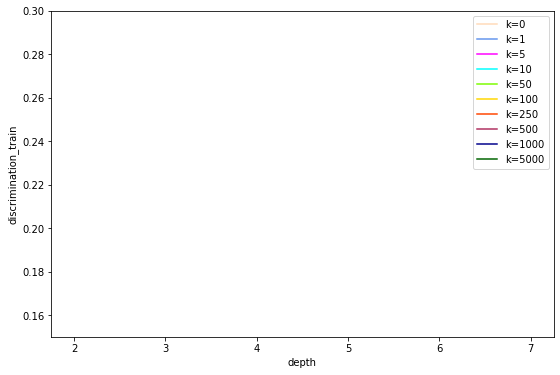

In [3]:
utils.plot_mean("depth", "discrimination_train", result, 0.15, 0.3)

<Figure size 648x432 with 0 Axes>

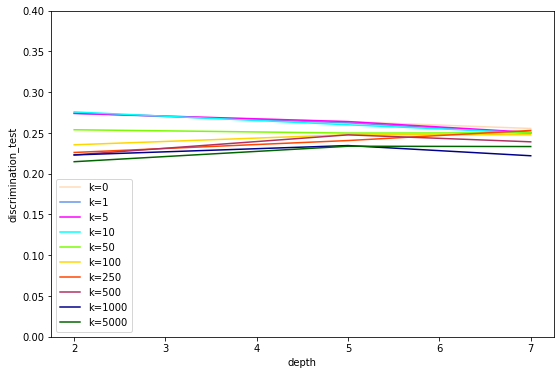

In [4]:
utils.plot_mean("depth", "discrimination_test", result, 0, 0.4)

<Figure size 648x432 with 0 Axes>

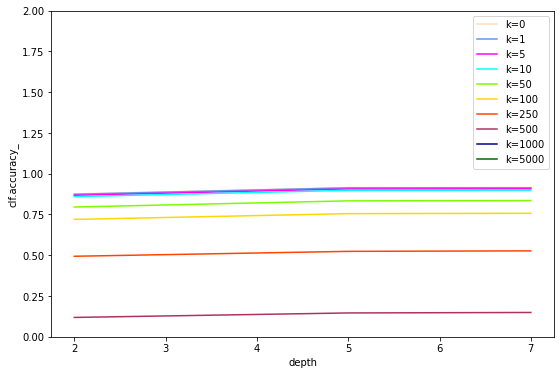

In [5]:
utils.plot_mean("depth", "clf.accuracy_", result, 0, 2)

<Figure size 648x432 with 0 Axes>

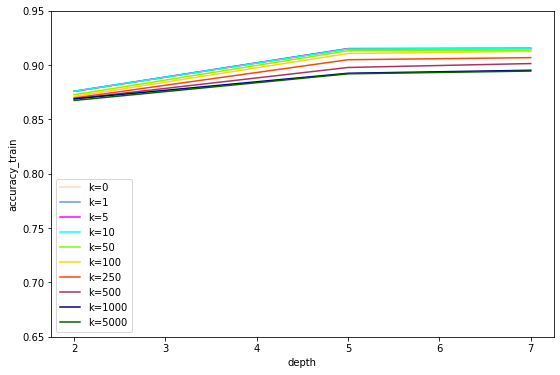

In [6]:
utils.plot_mean("depth", "accuracy_train", result, 0.65, 0.95)

<Figure size 648x432 with 0 Axes>

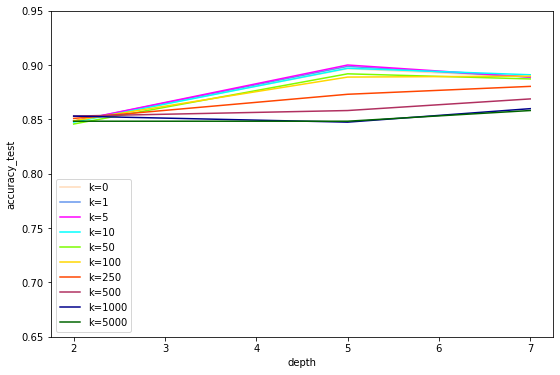

In [7]:
utils.plot_mean("depth", "accuracy_test", result, 0.65, 0.95)

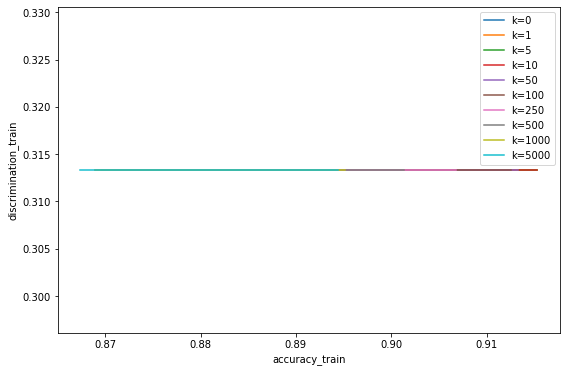

In [8]:
utils.plot2("accuracy_train", "discrimination_train", result)

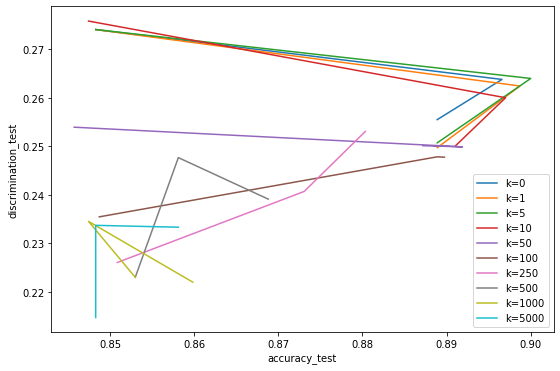

In [9]:
utils.plot2("accuracy_test", "discrimination_test", result)

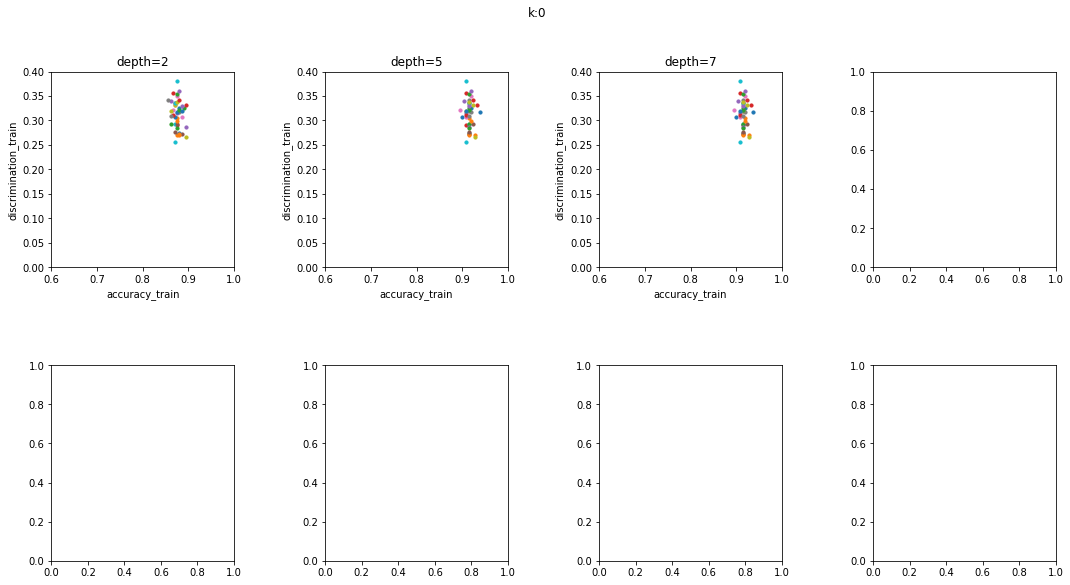

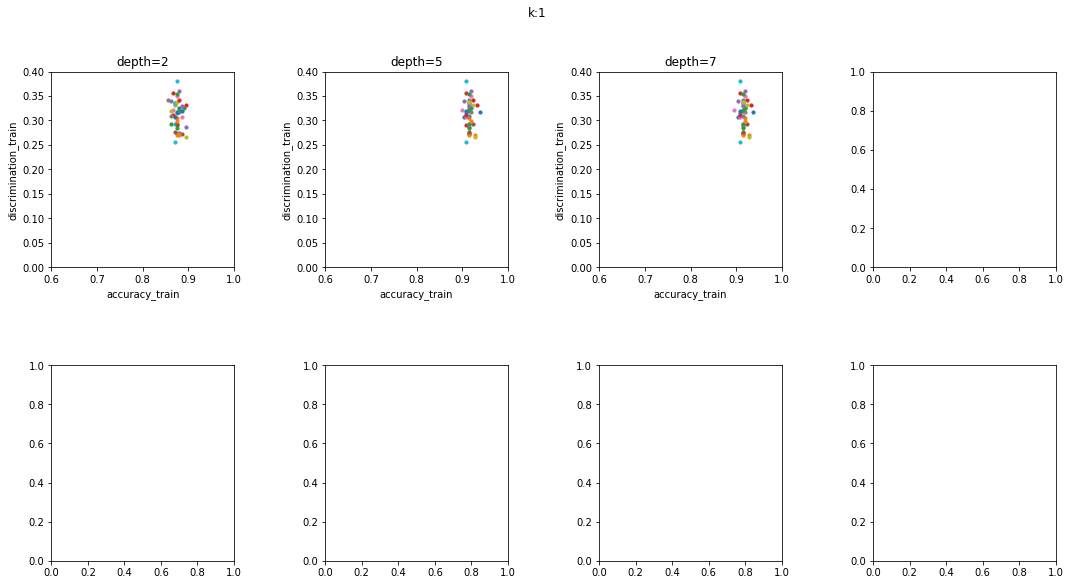

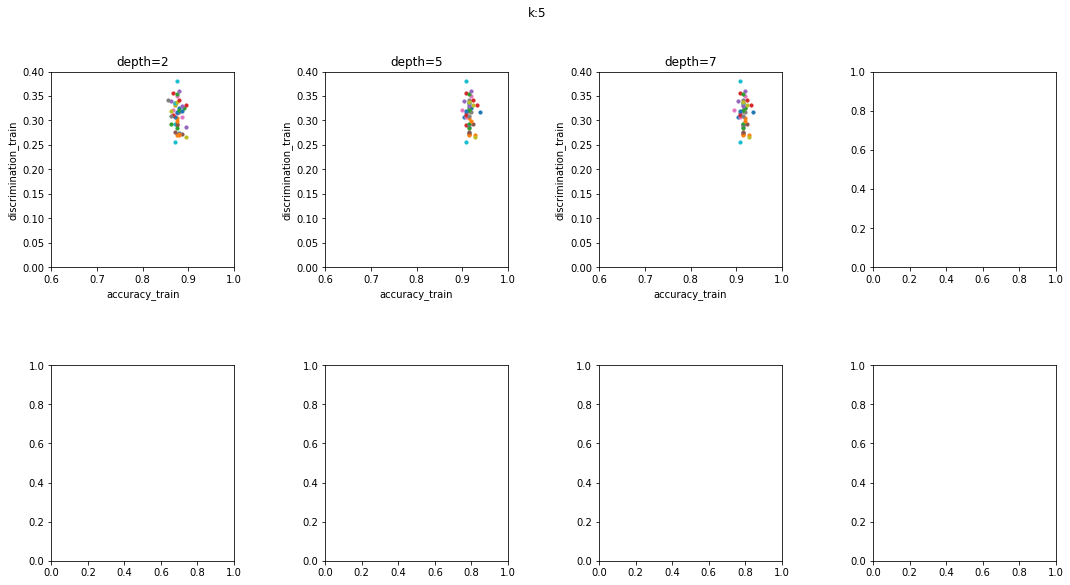

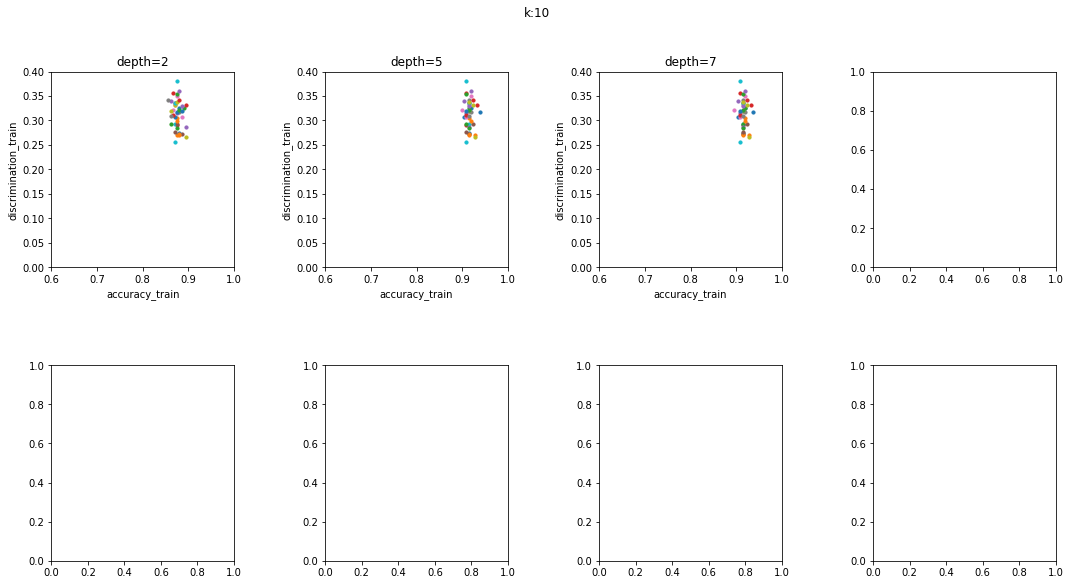

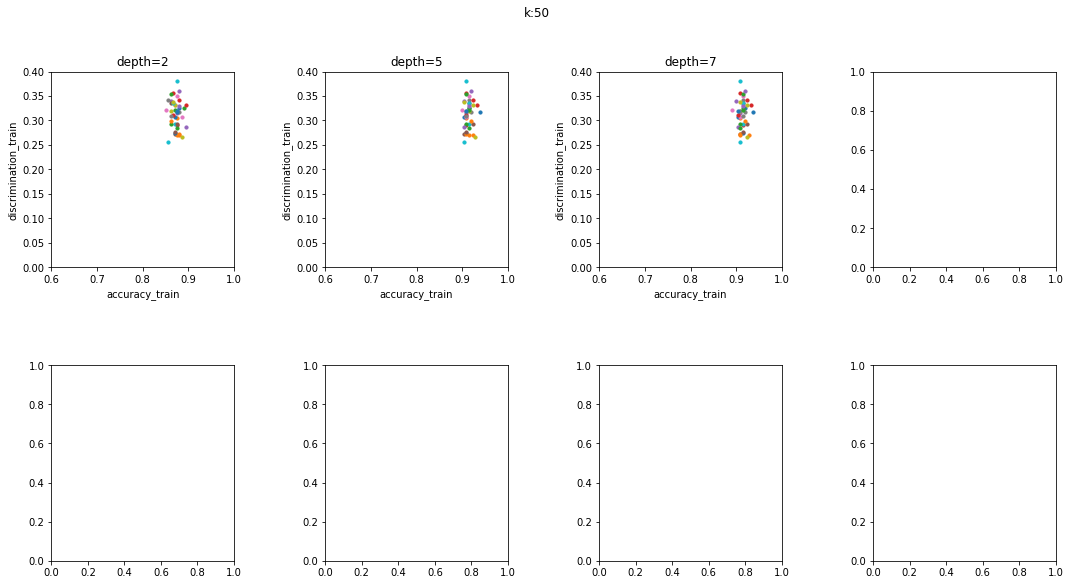

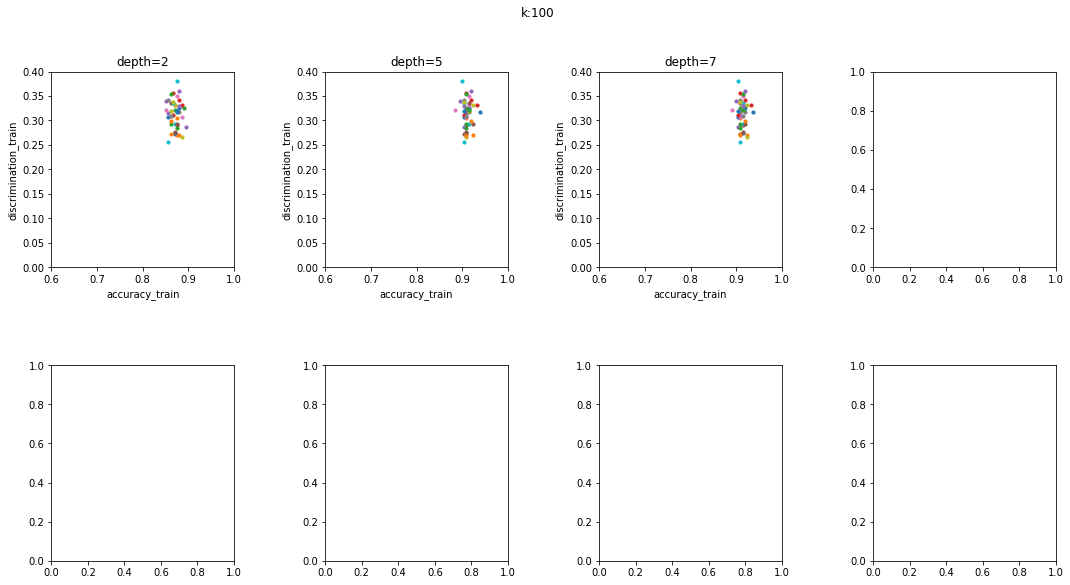

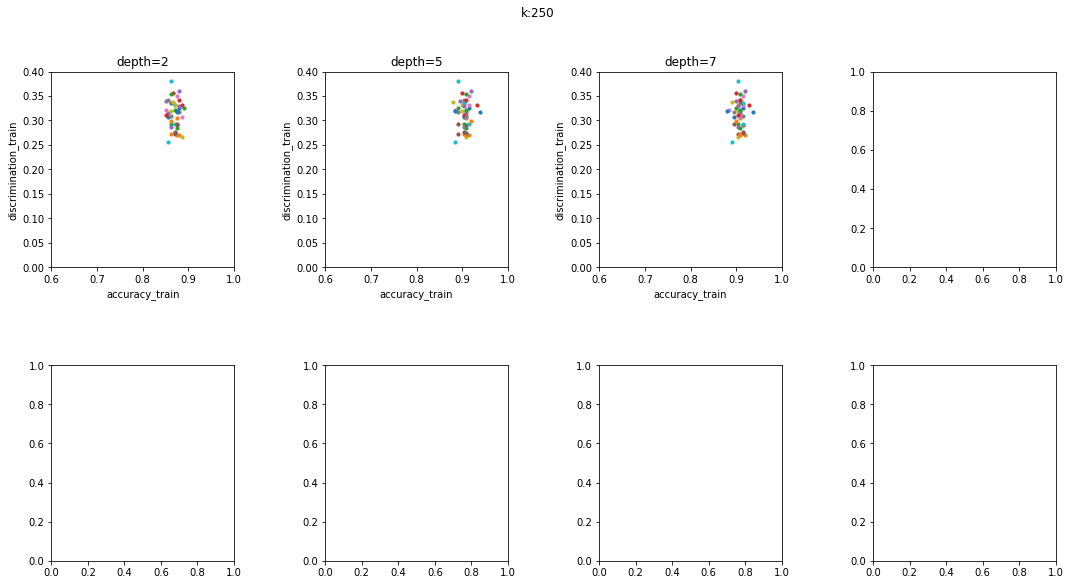

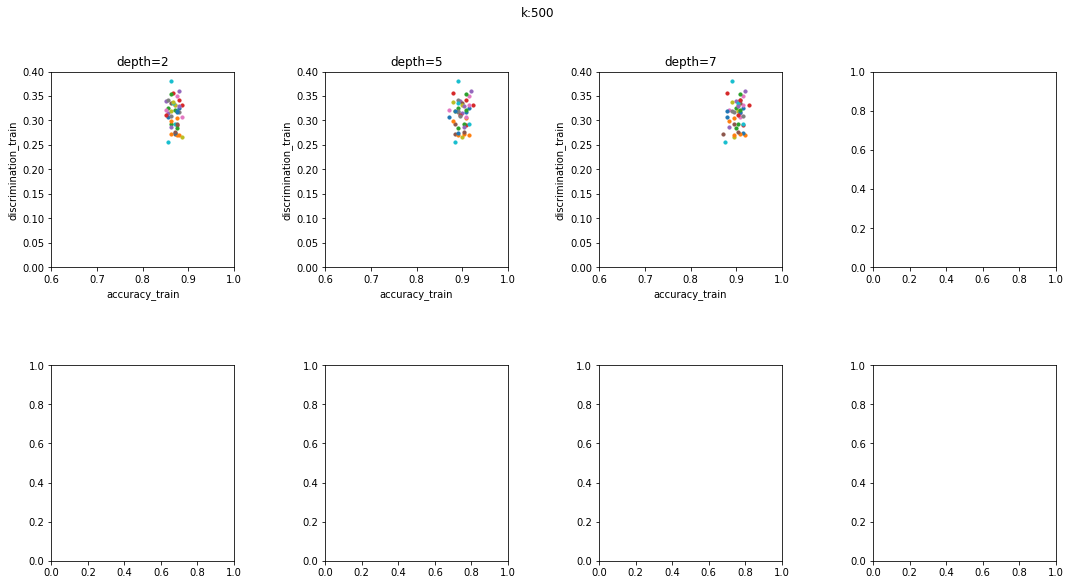

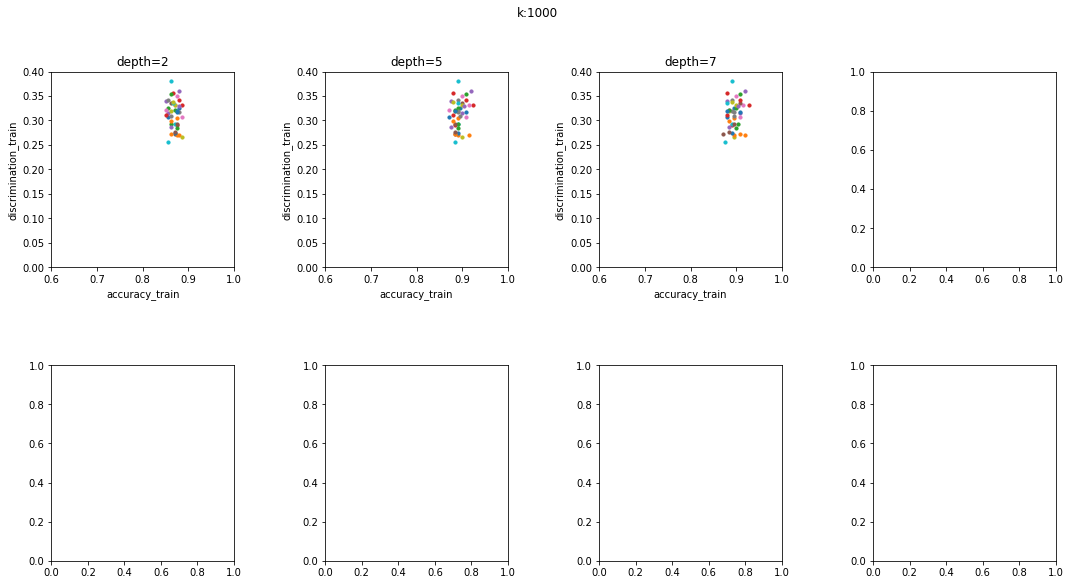

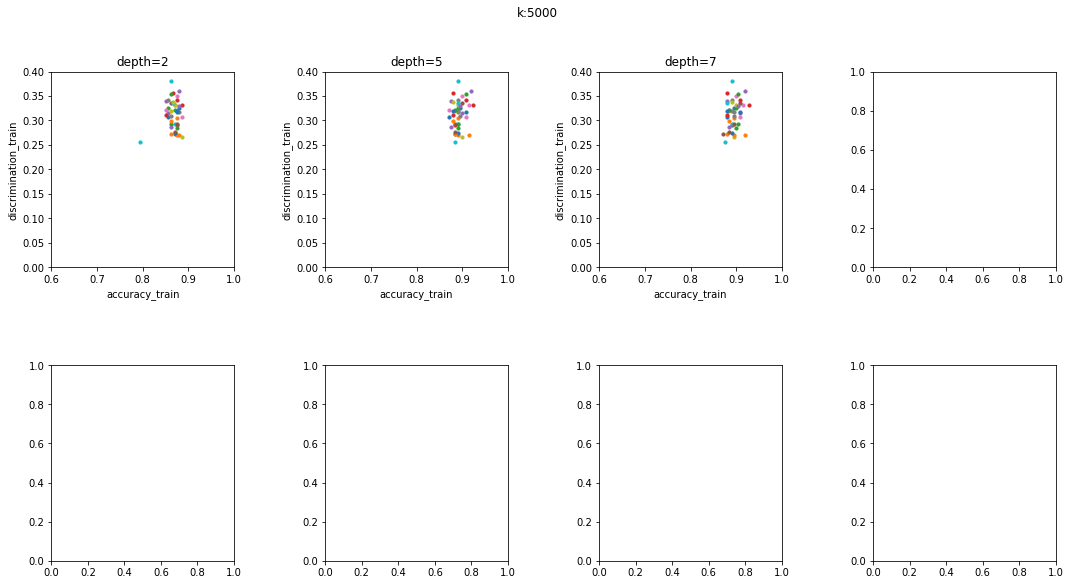

In [10]:
utils.plot_one_scatter_by_depth("accuracy_train", "discrimination_train", result, (0.6, 1), (0, 0.4))

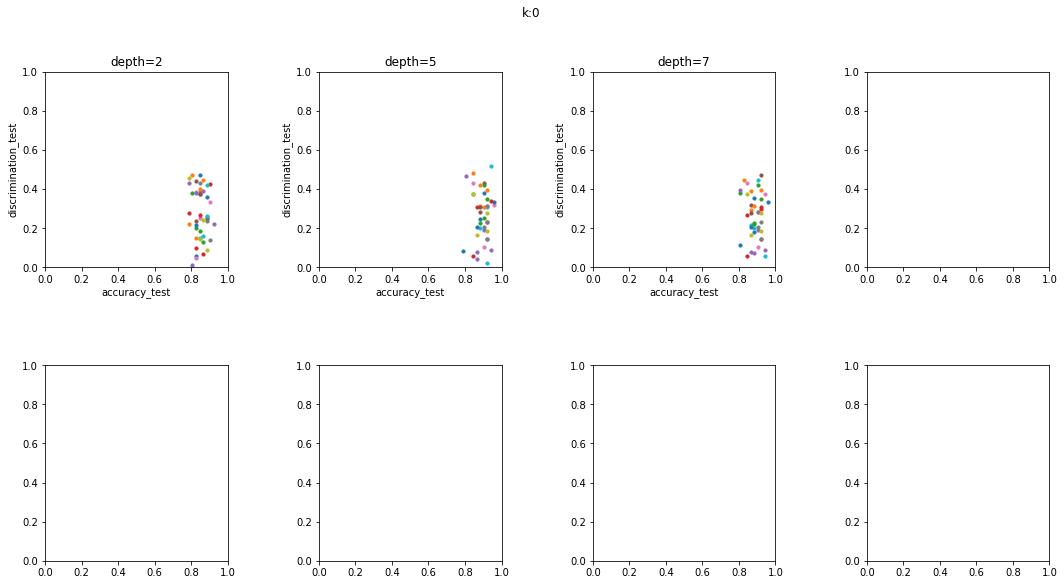

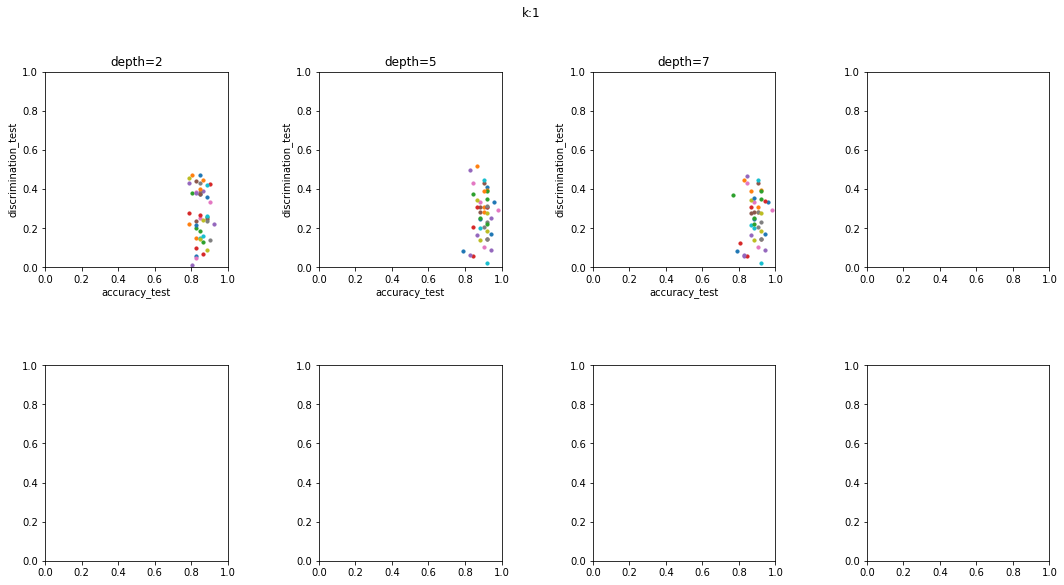

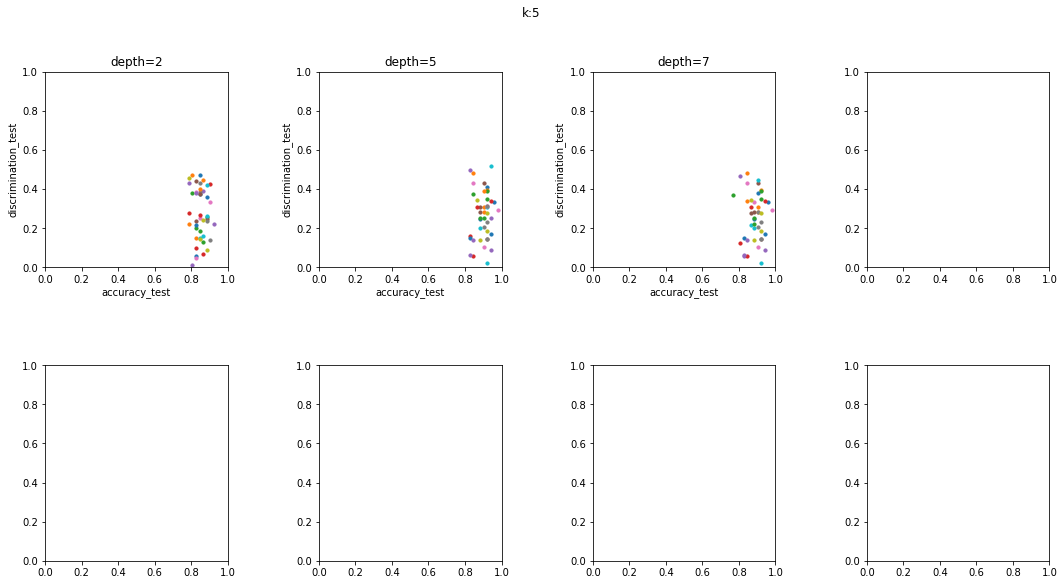

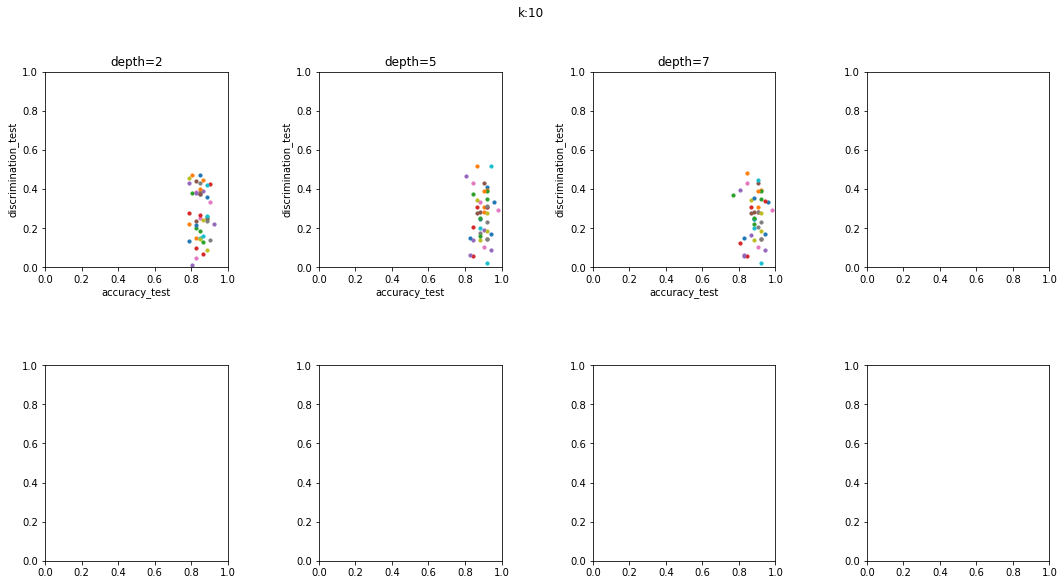

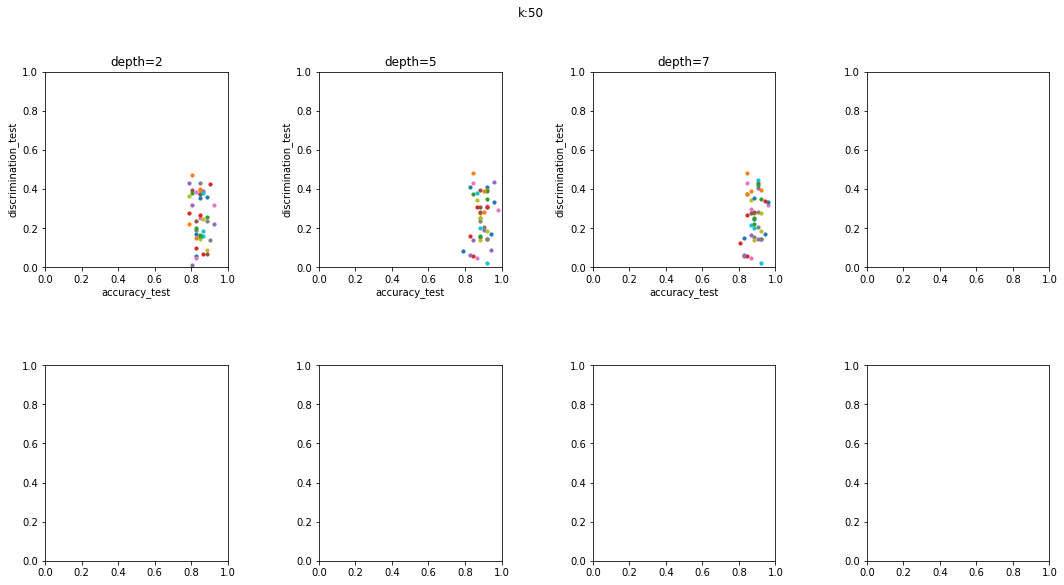

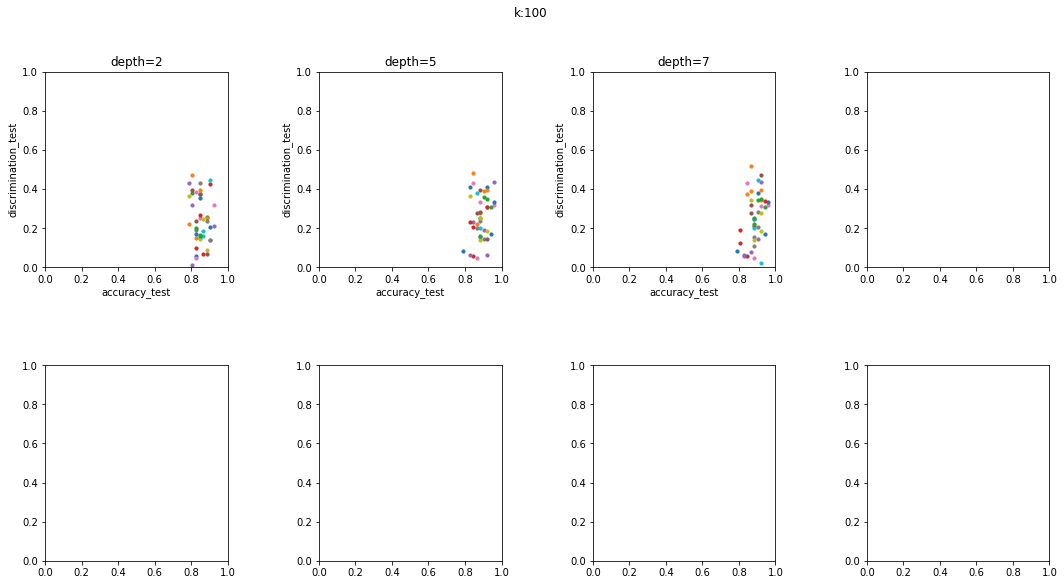

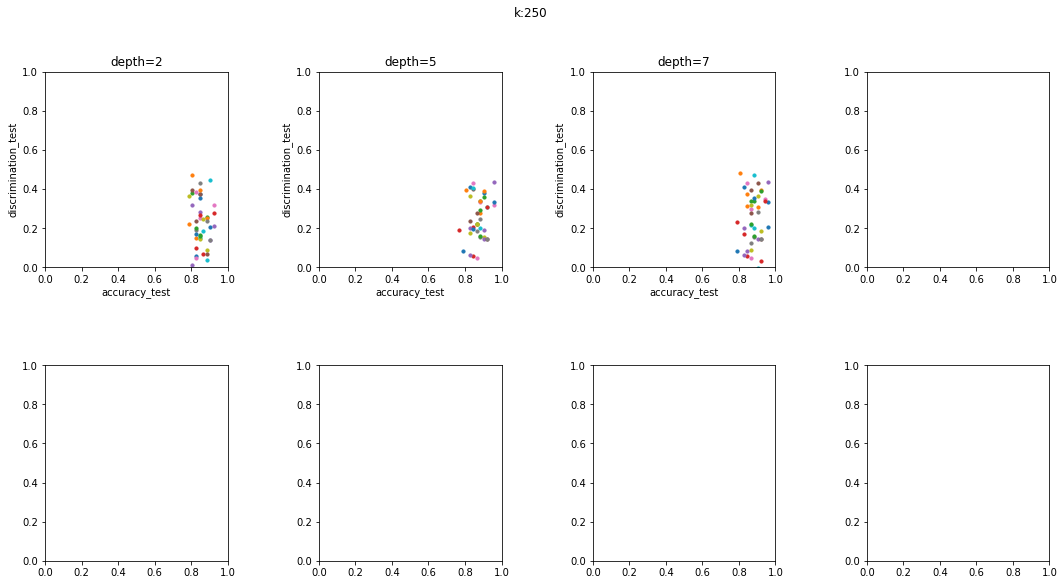

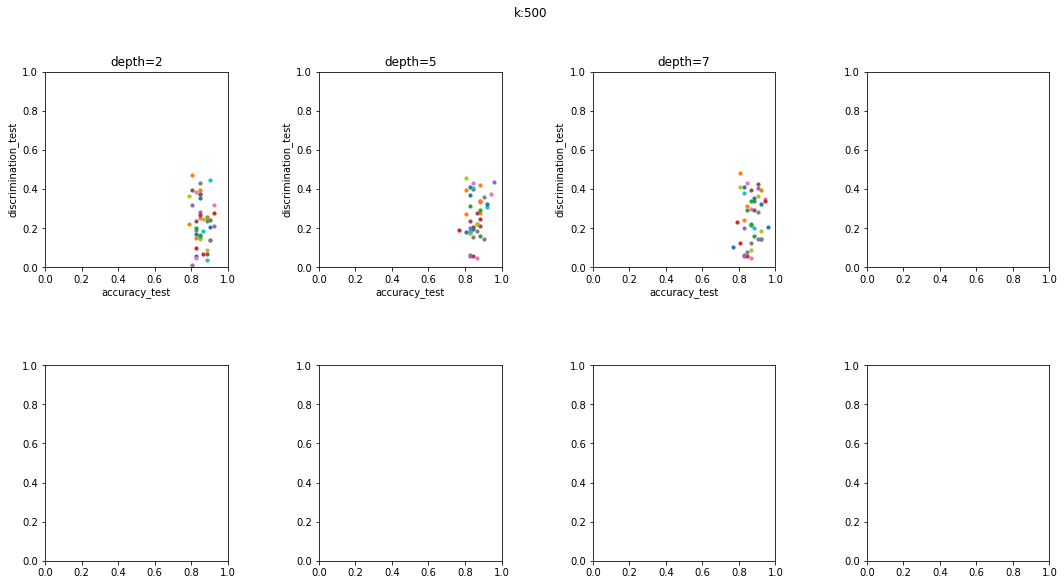

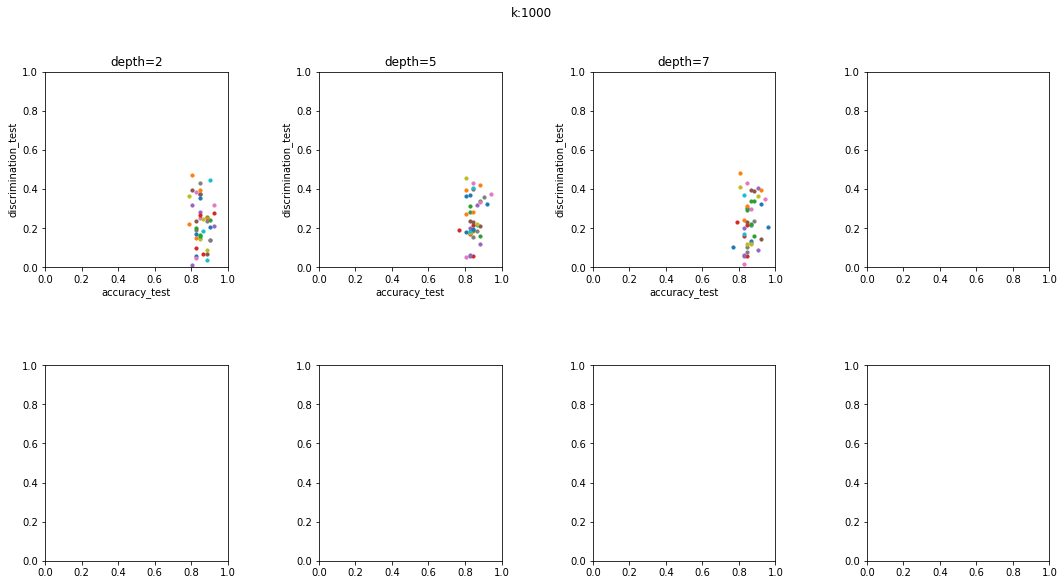

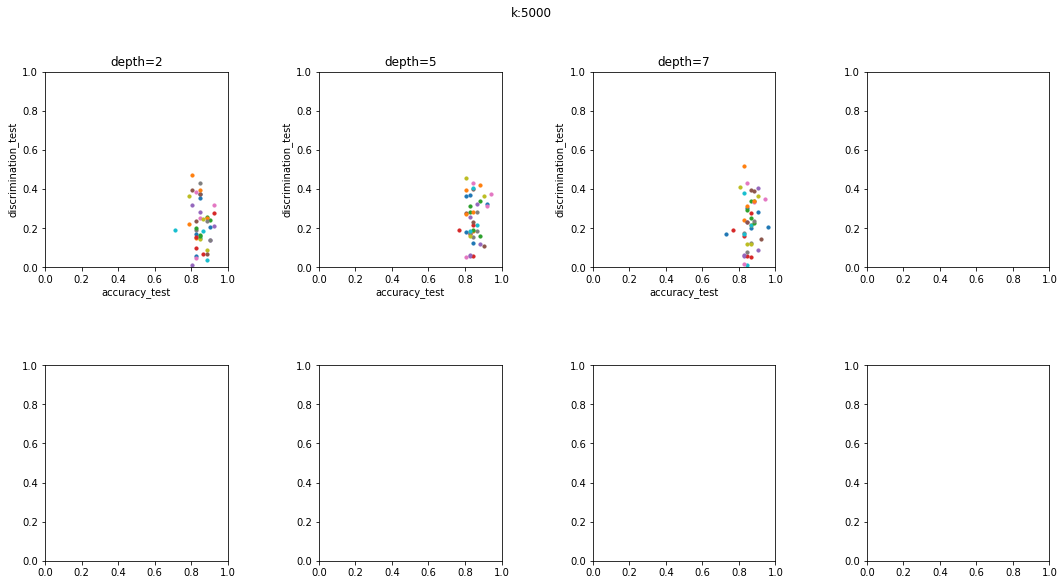

In [11]:
utils.plot_one_scatter_by_depth("accuracy_test", "discrimination_test", result, (0, 1), (0, 1))

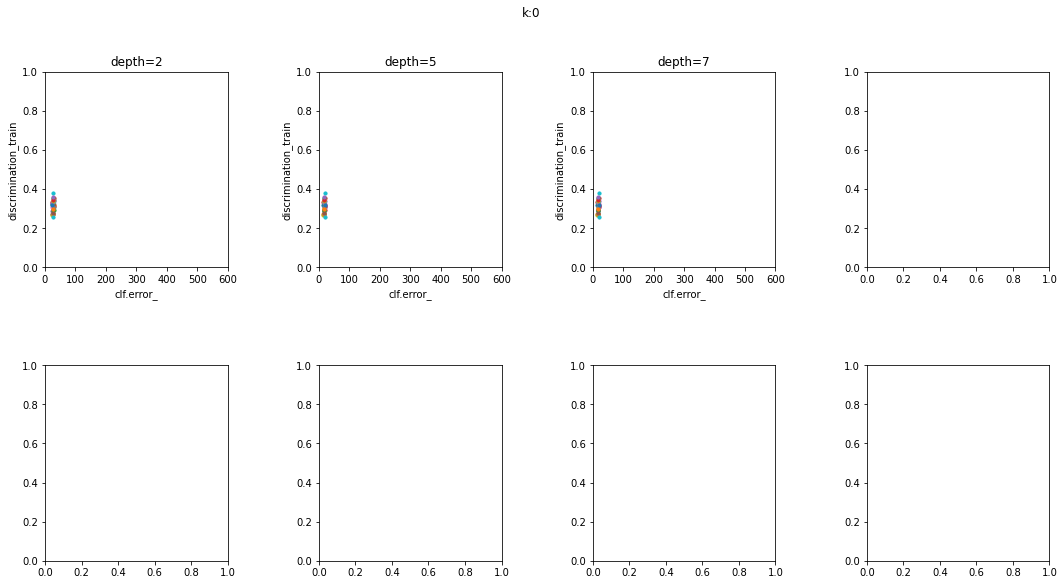

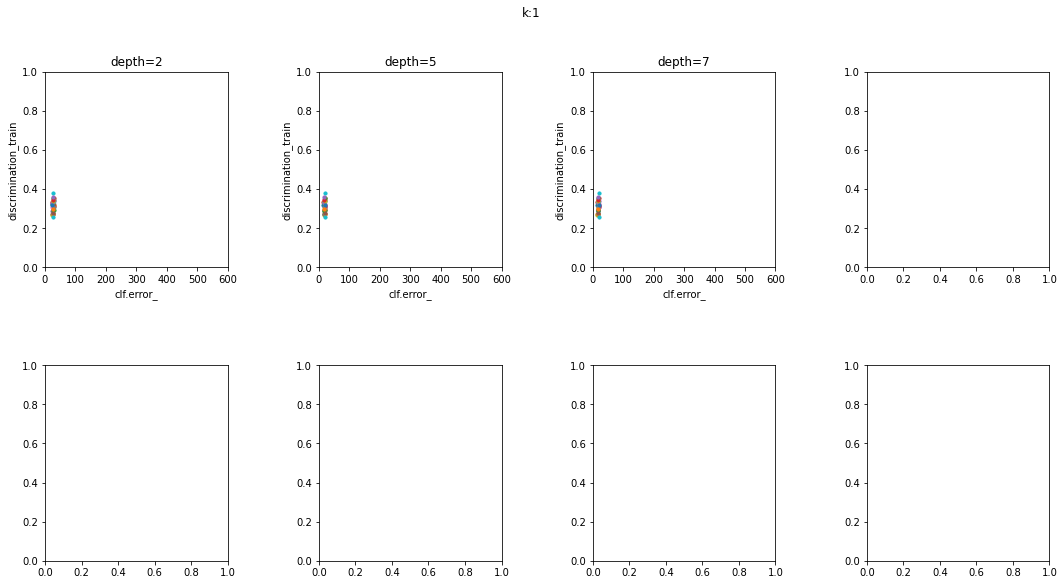

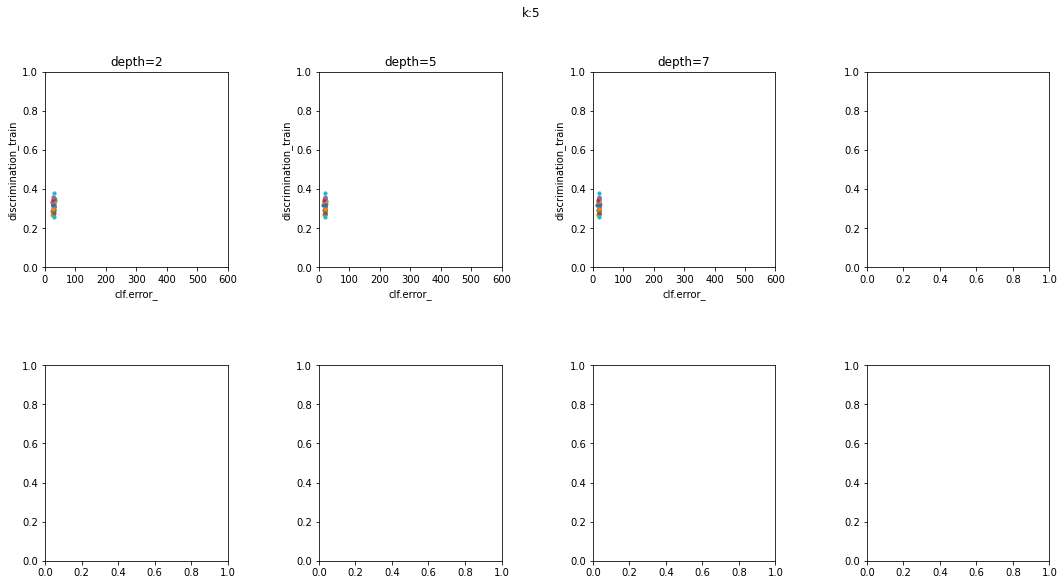

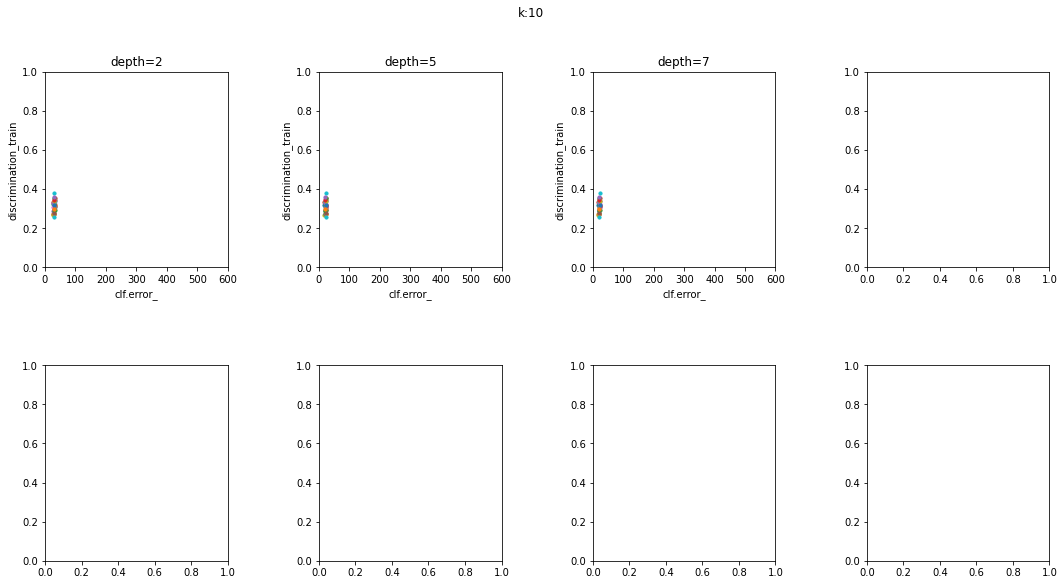

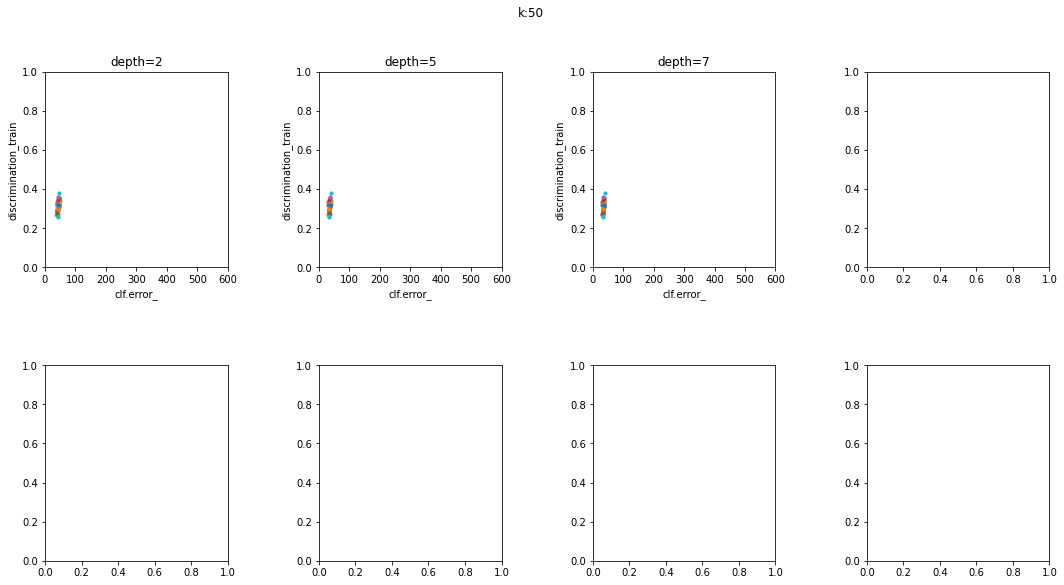

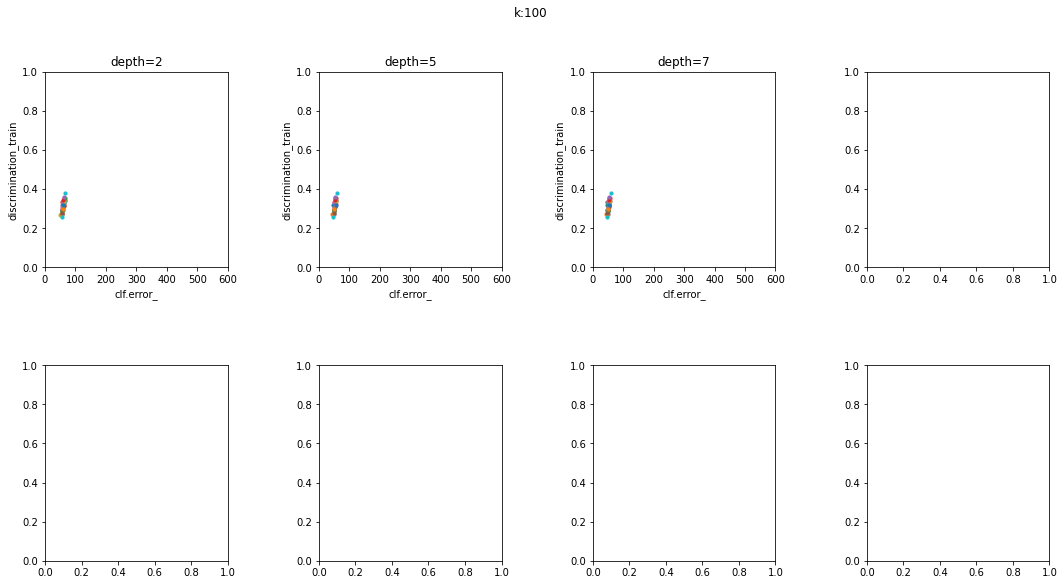

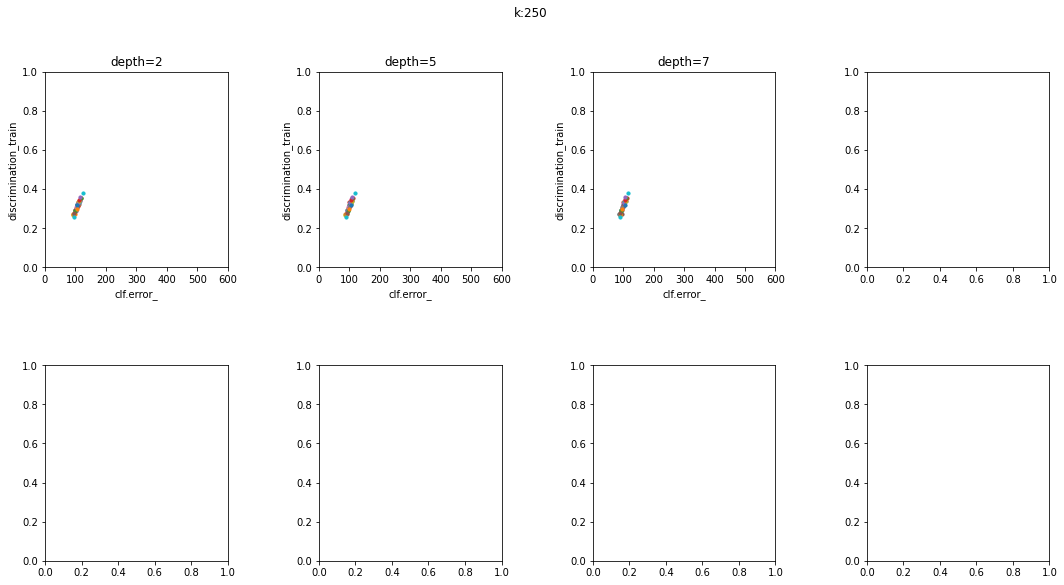

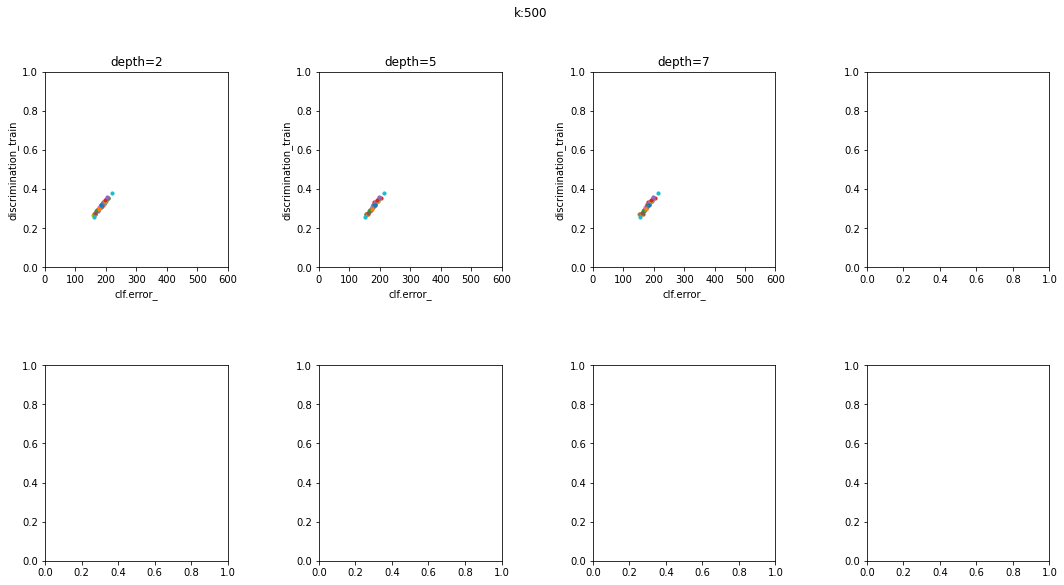

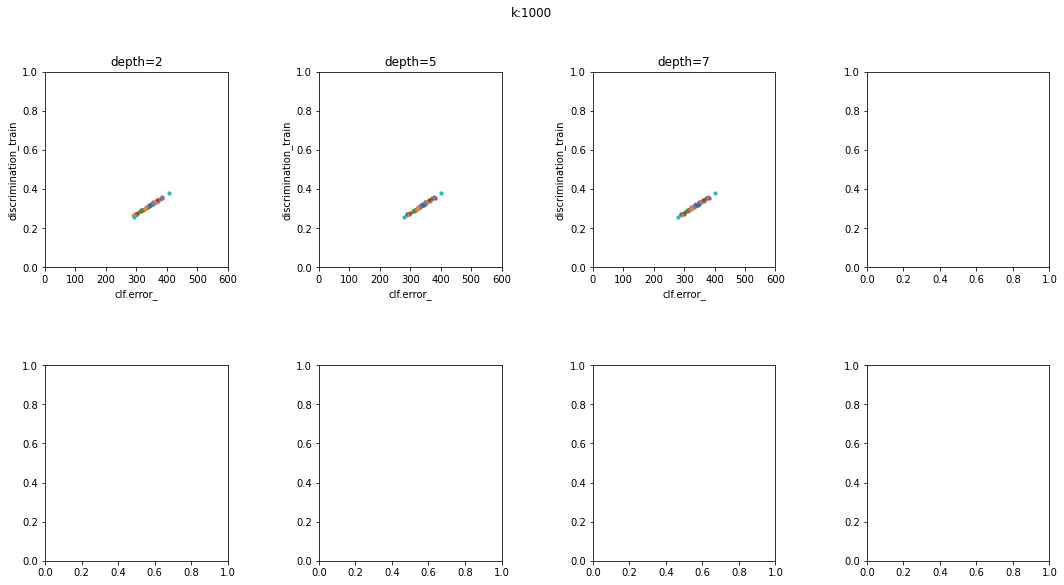

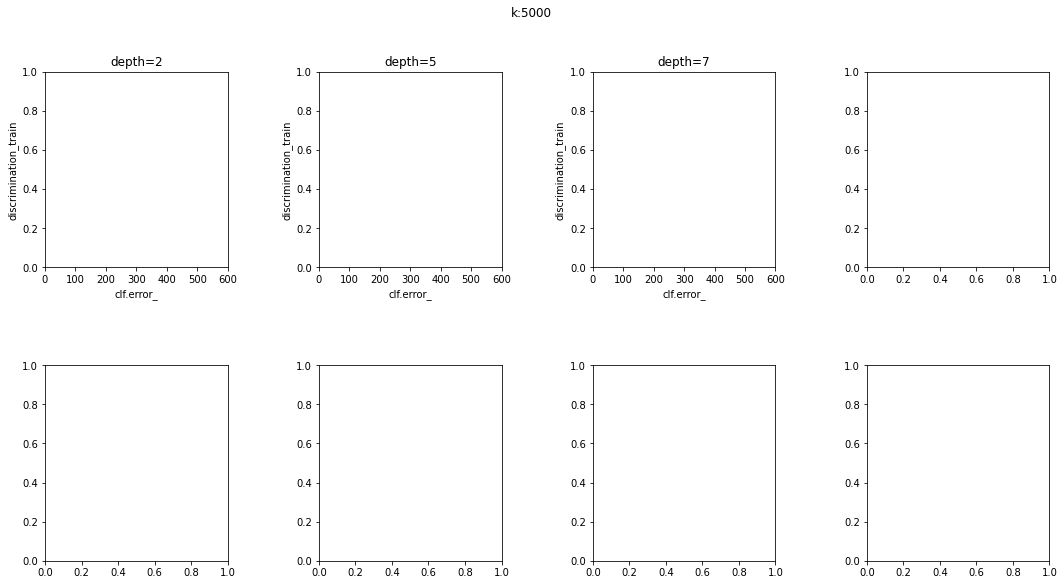

In [12]:
utils.plot_one_scatter_by_depth("clf.error_", "discrimination_train", result, (0, 600), (0, 1))

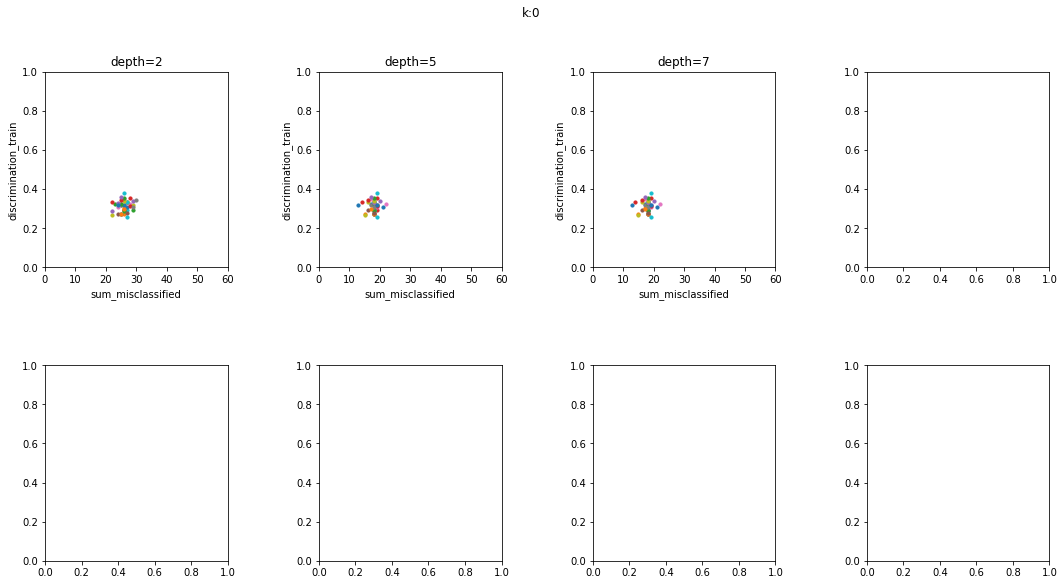

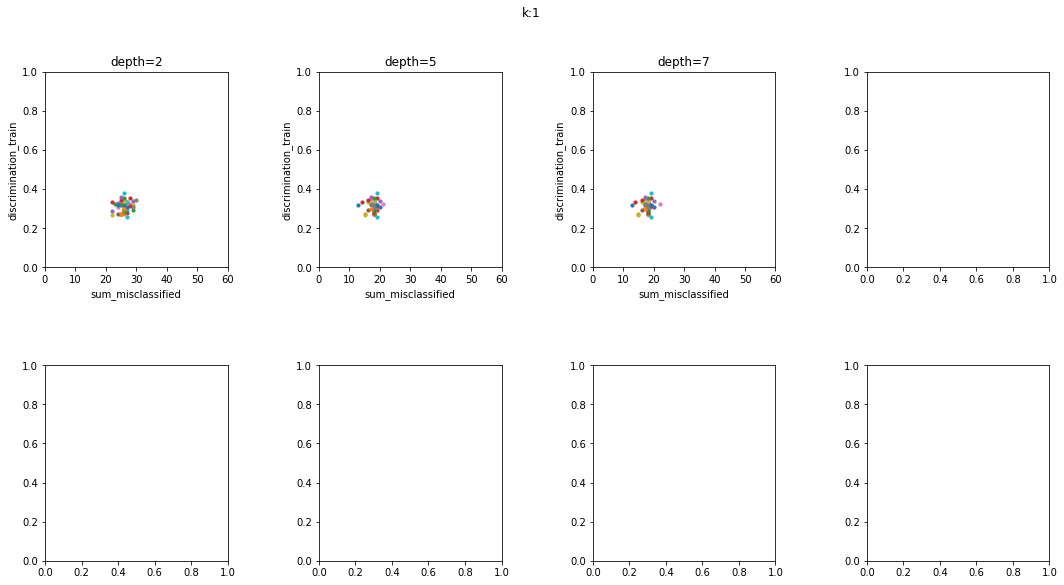

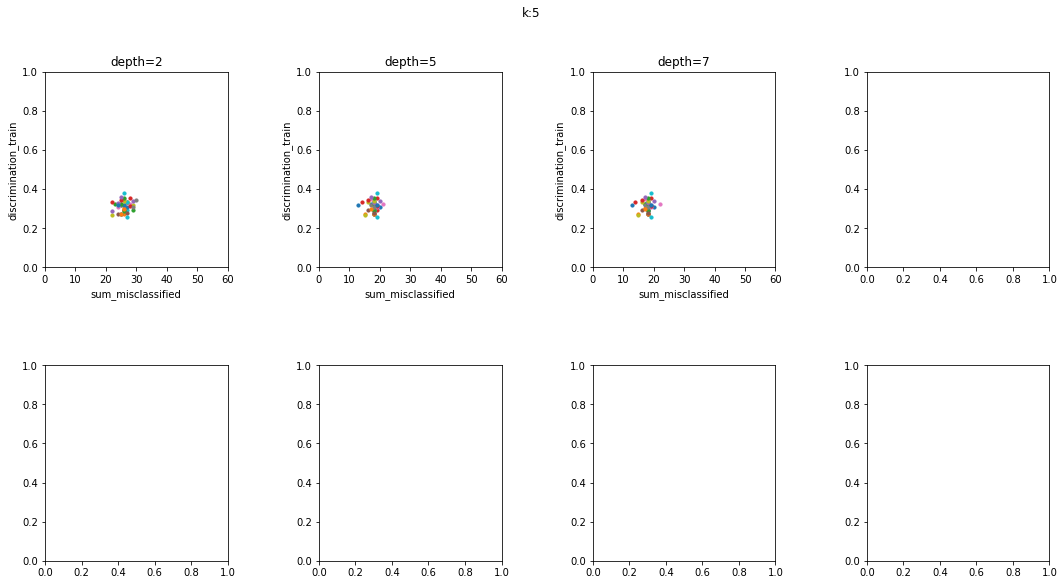

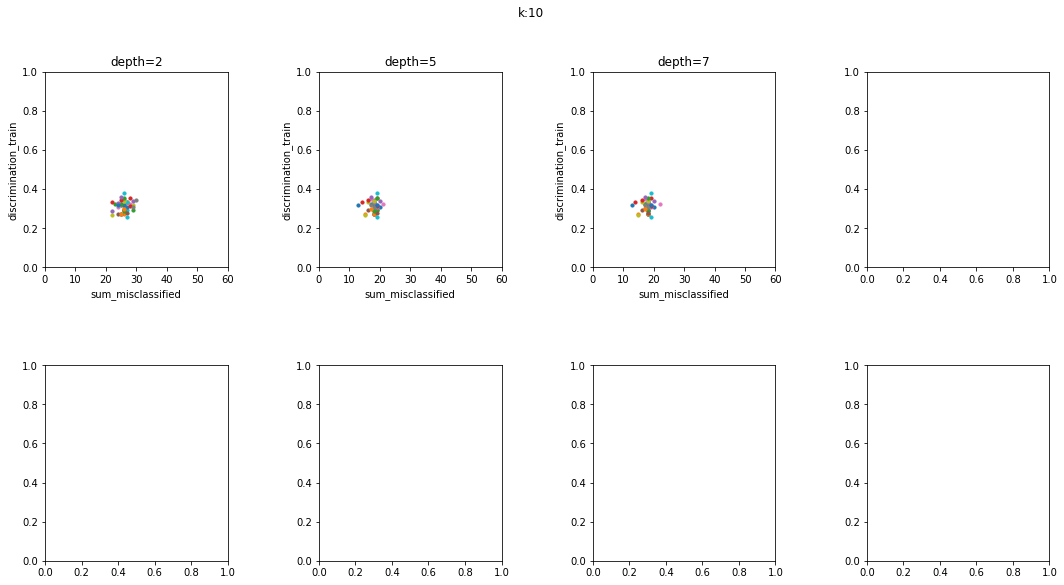

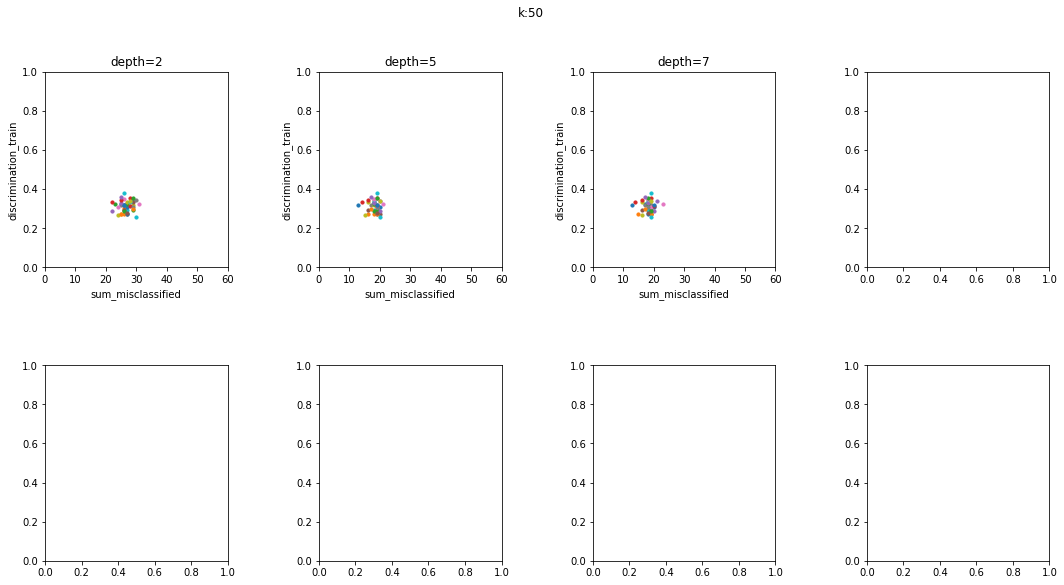

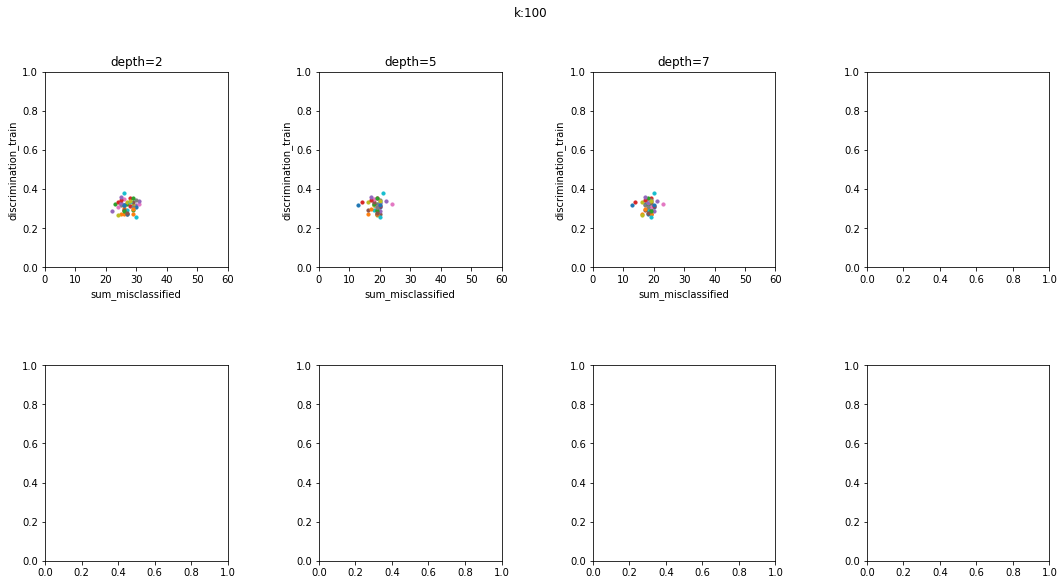

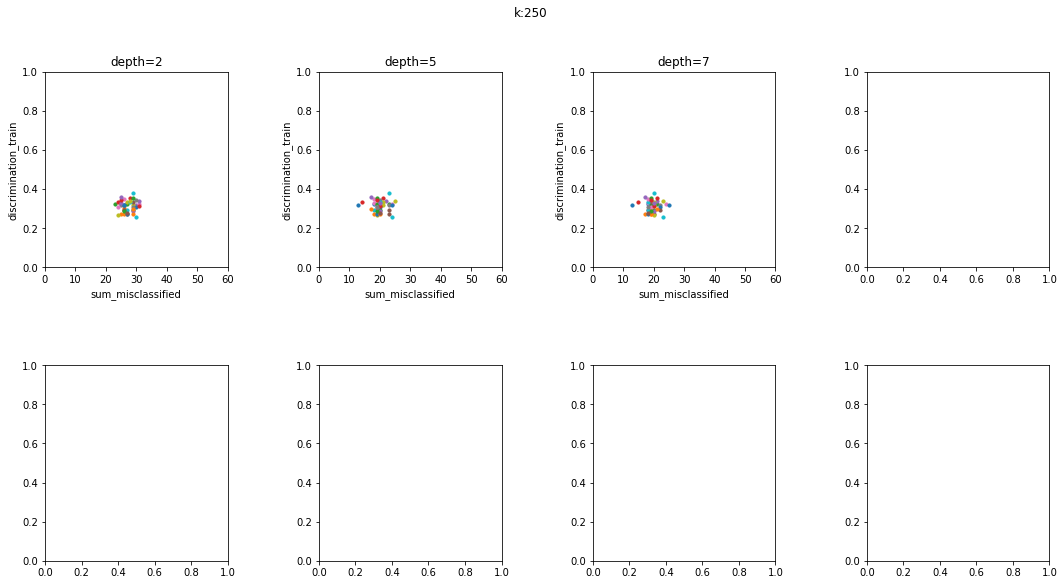

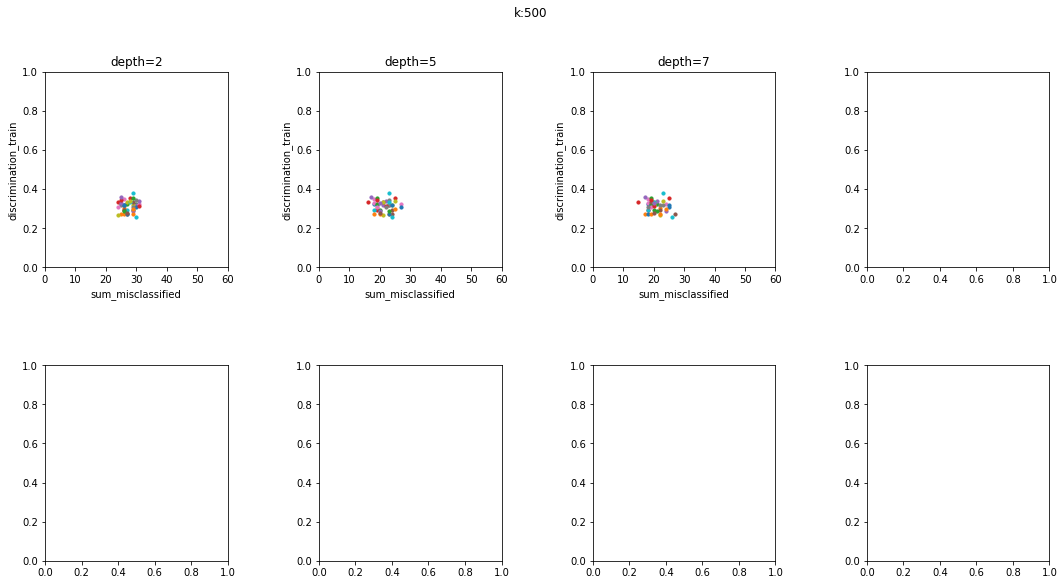

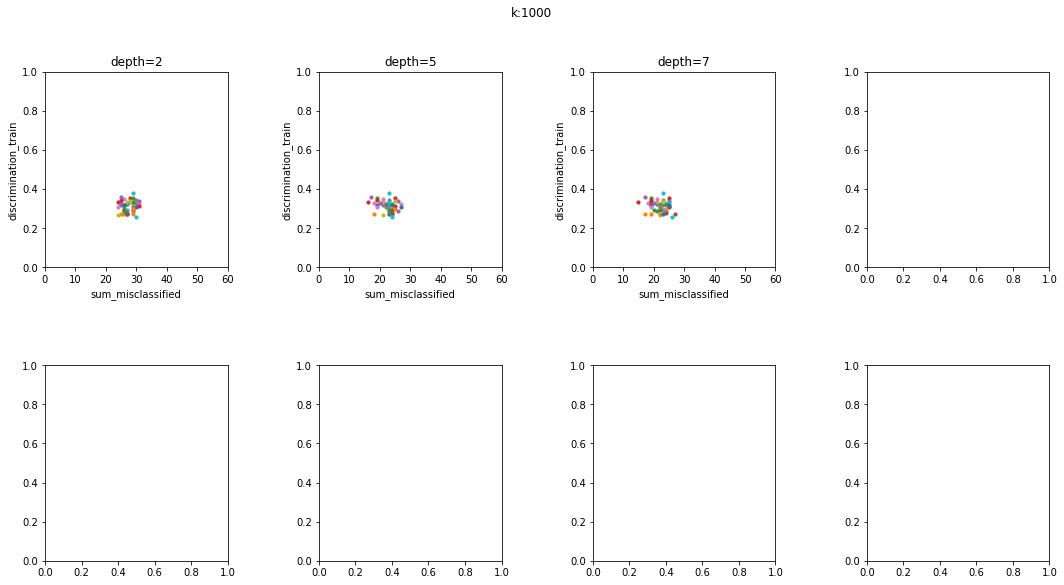

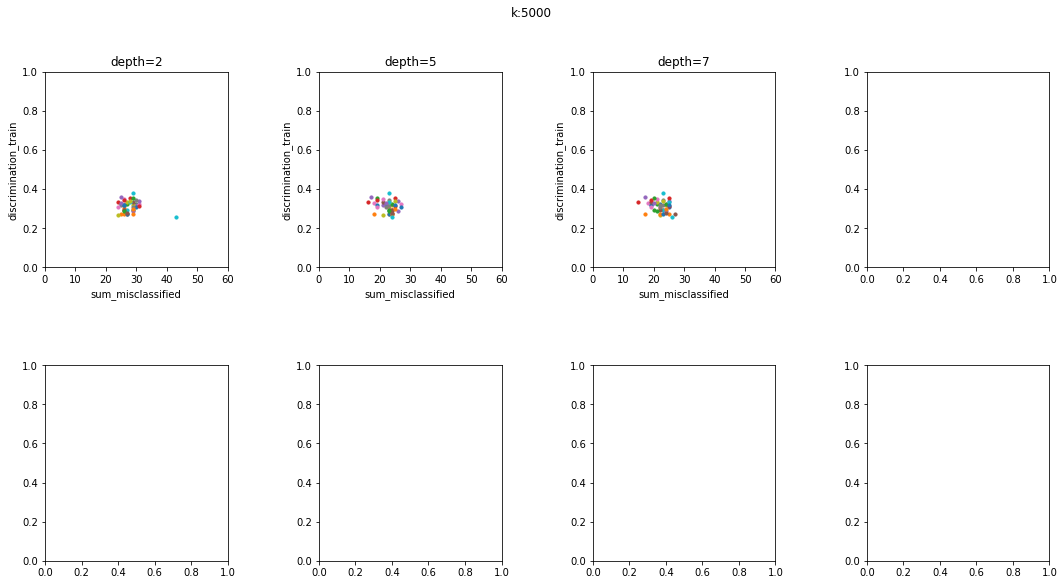

In [13]:
utils.plot_one_scatter_by_depth("sum_misclassified", "discrimination_train", result, (0, 60), (0, 1))

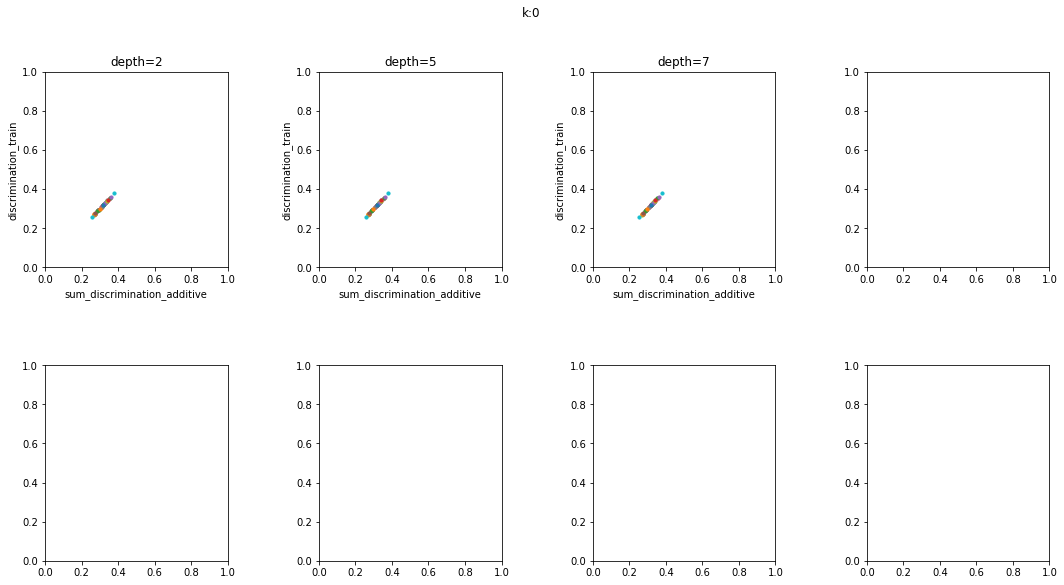

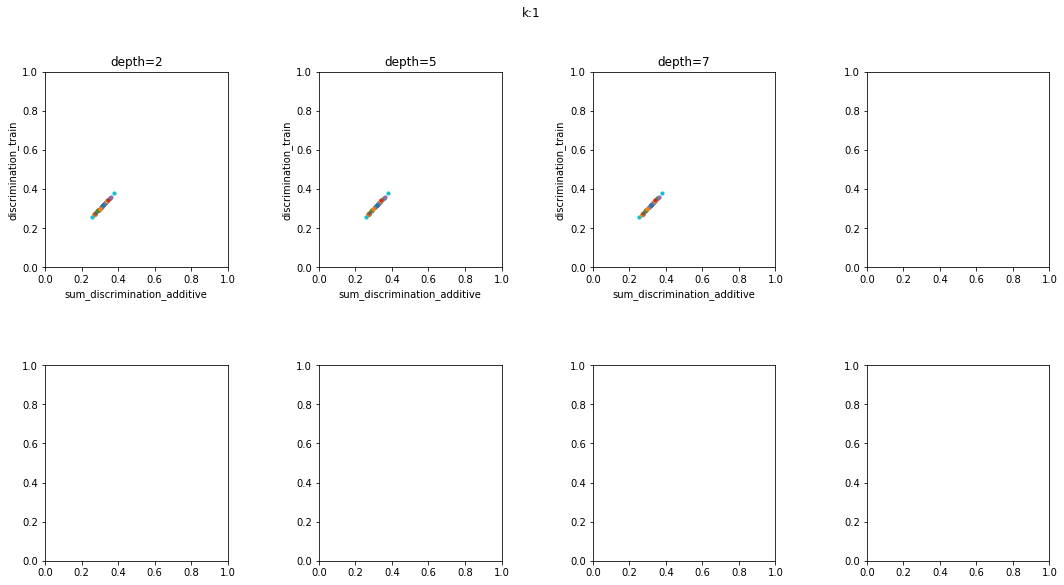

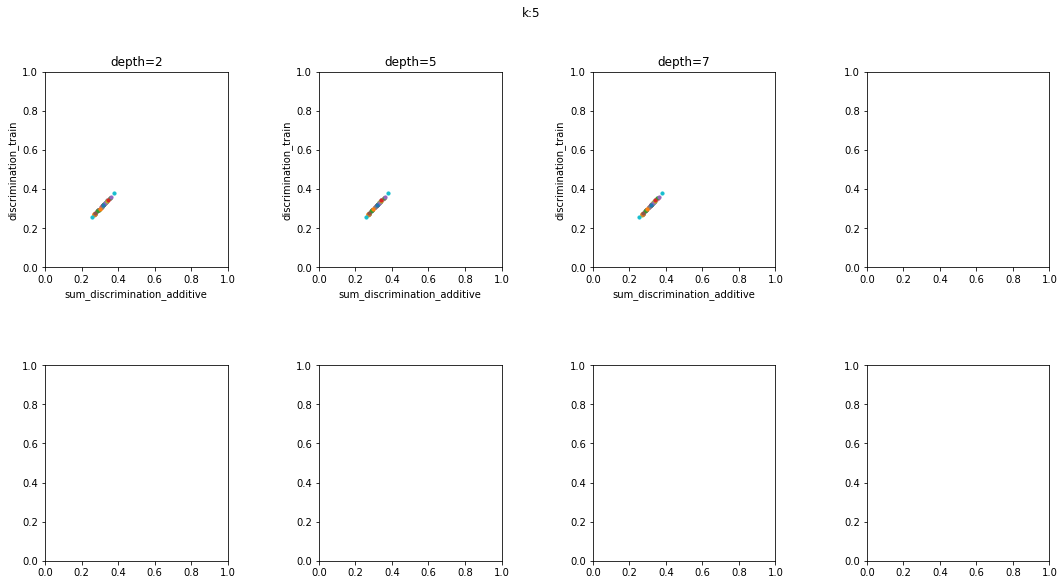

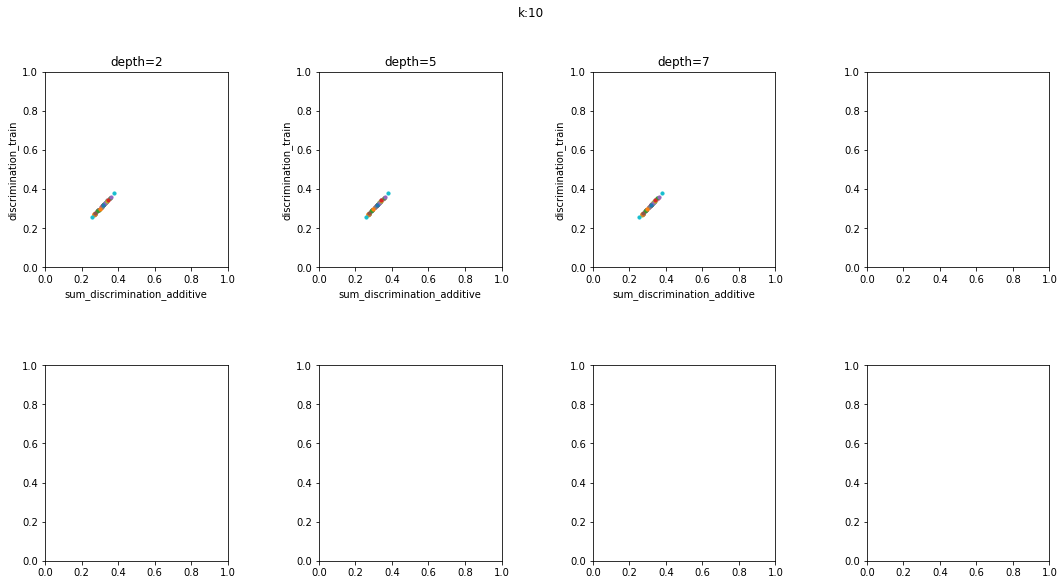

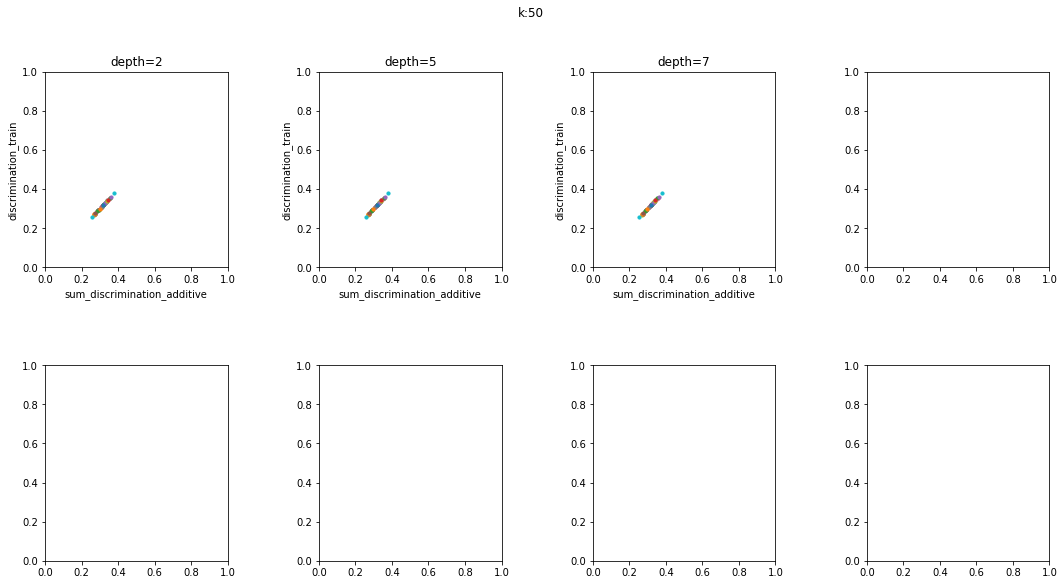

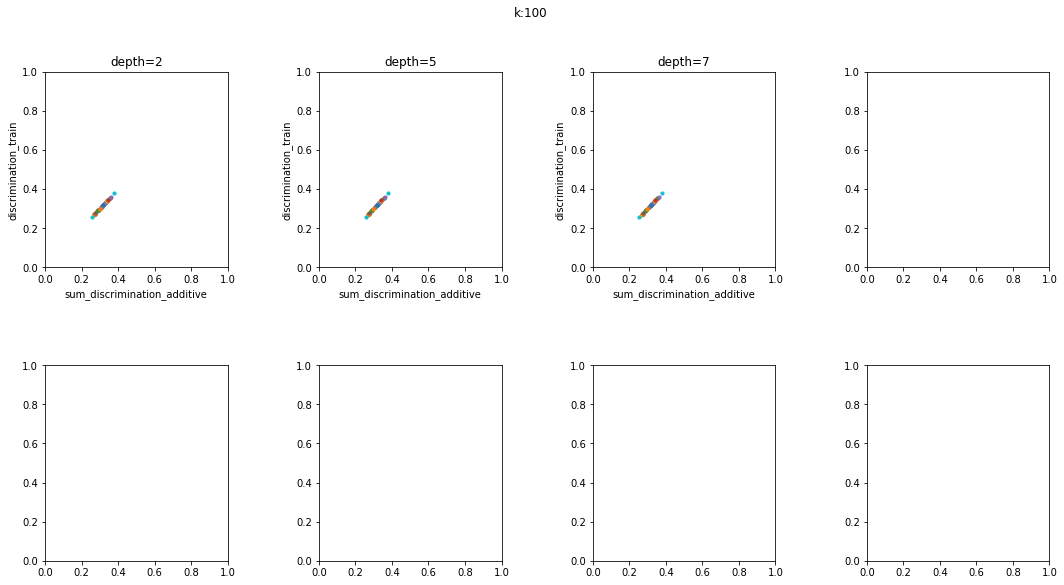

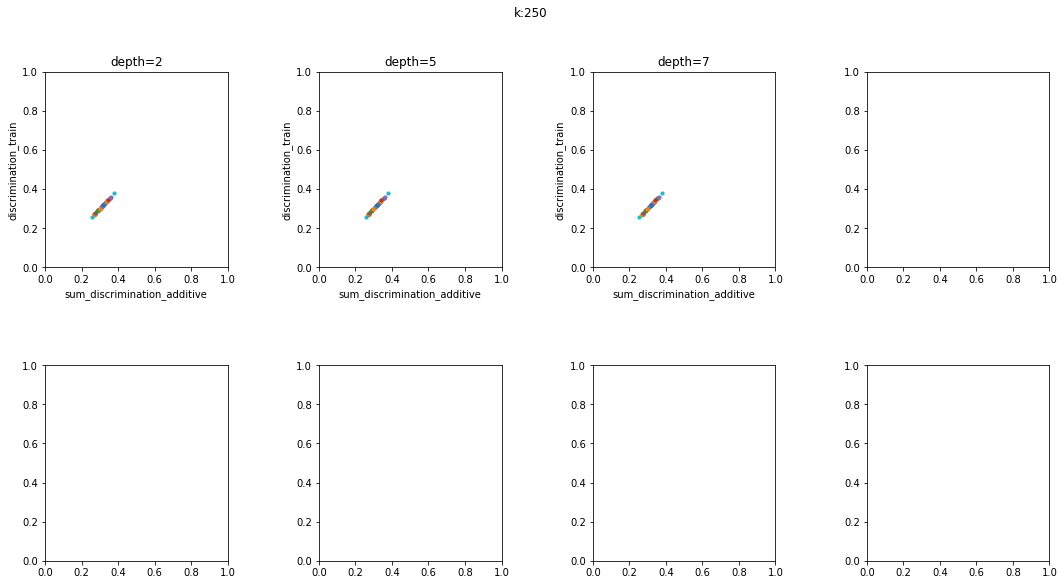

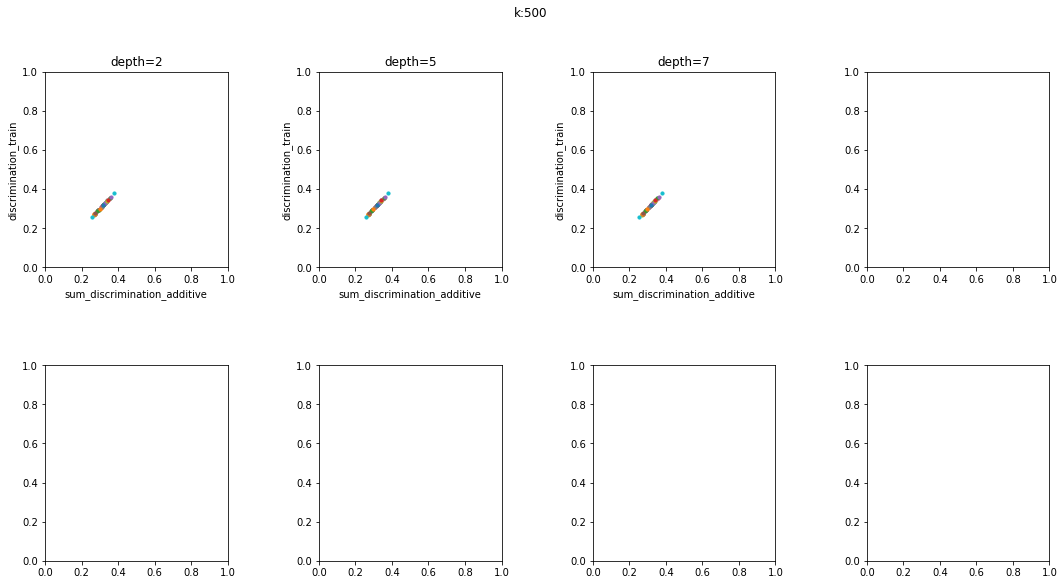

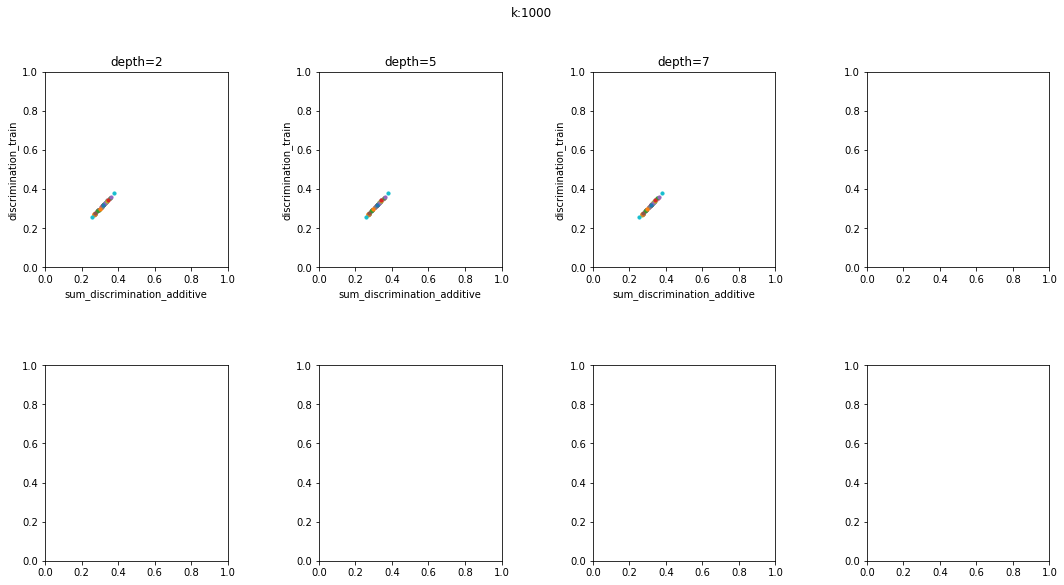

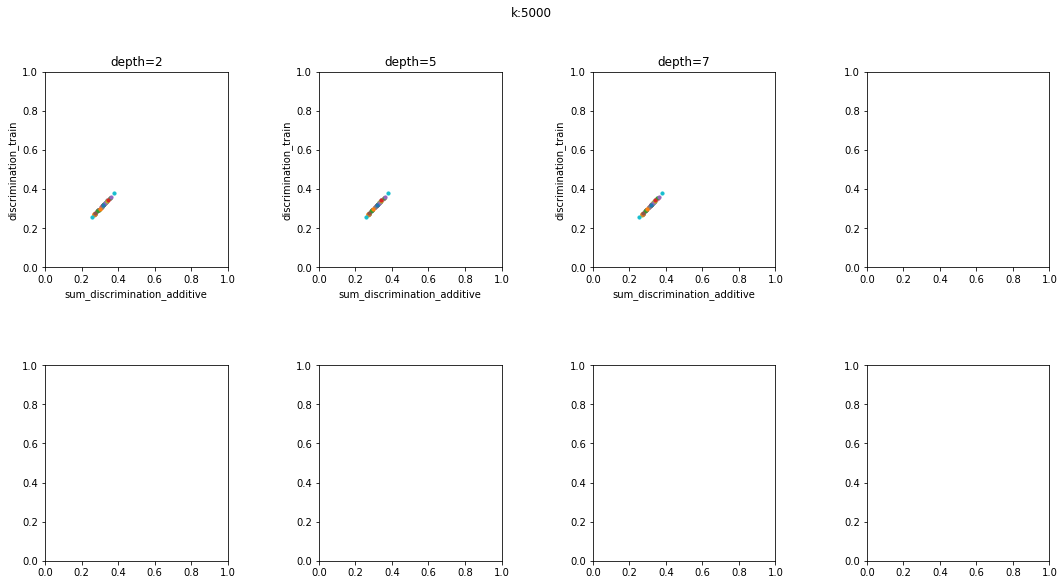

In [14]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive", "discrimination_train", result, (0, 1), (0, 1))

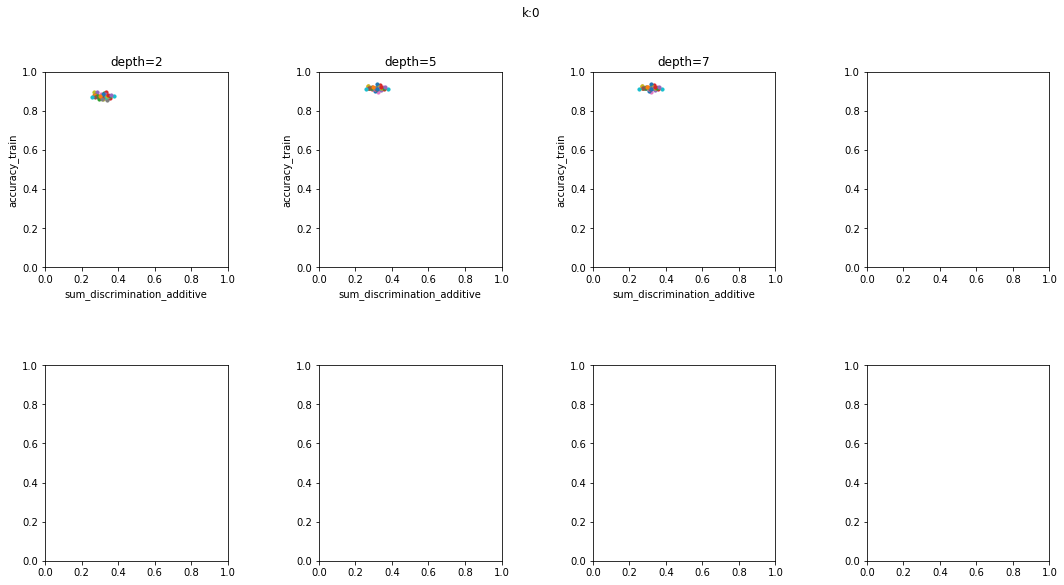

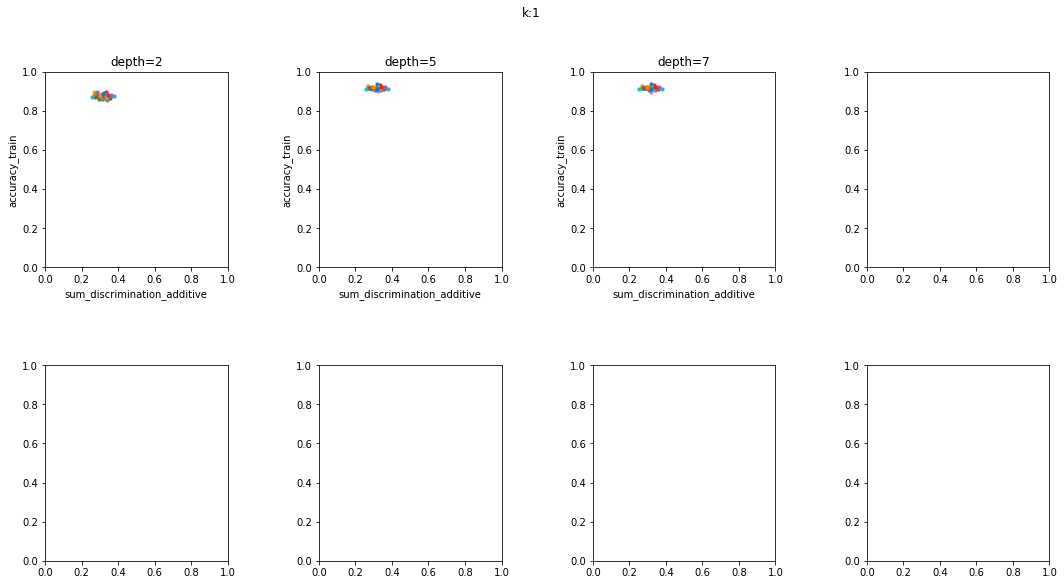

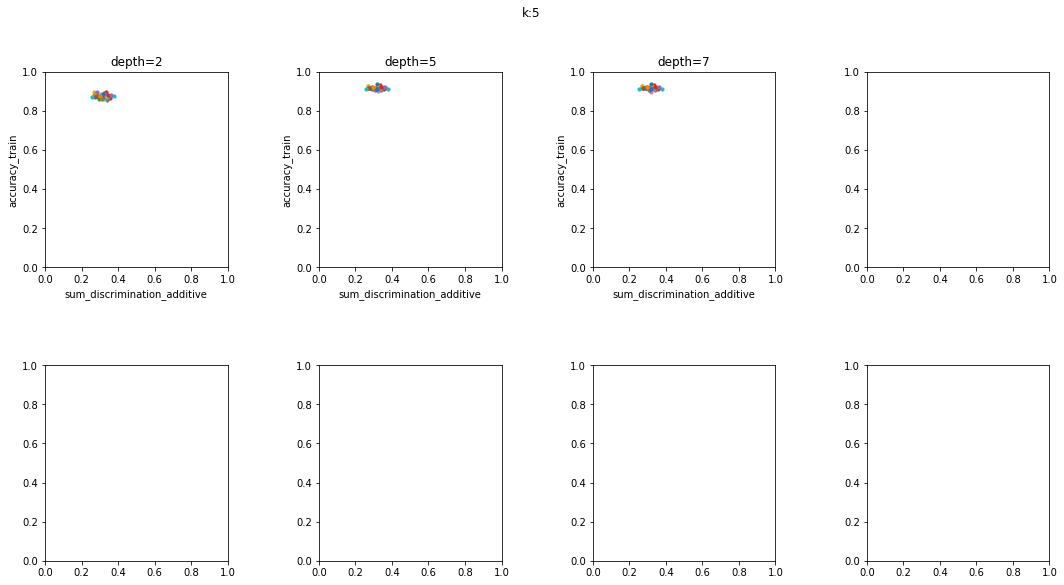

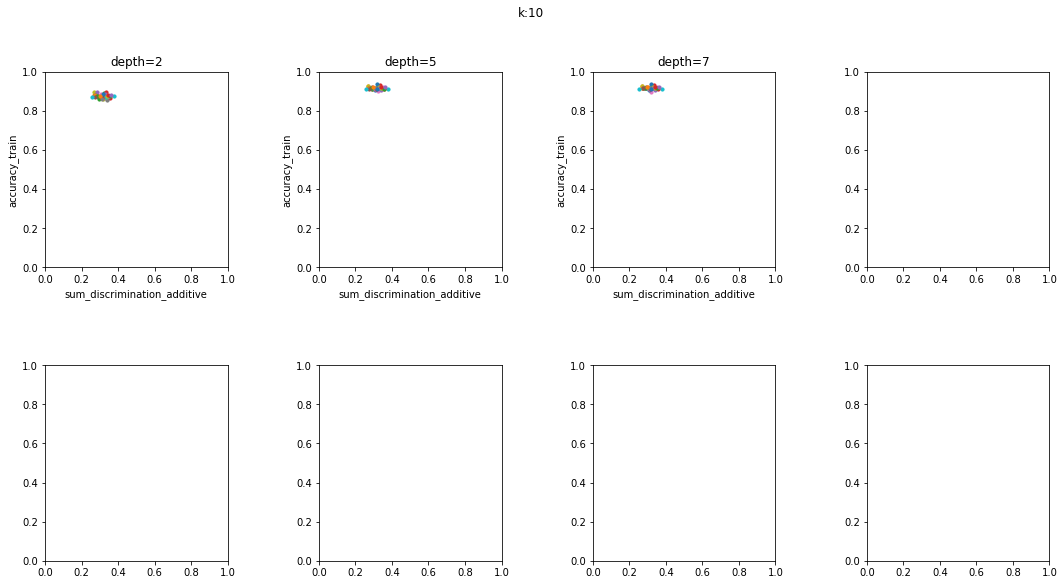

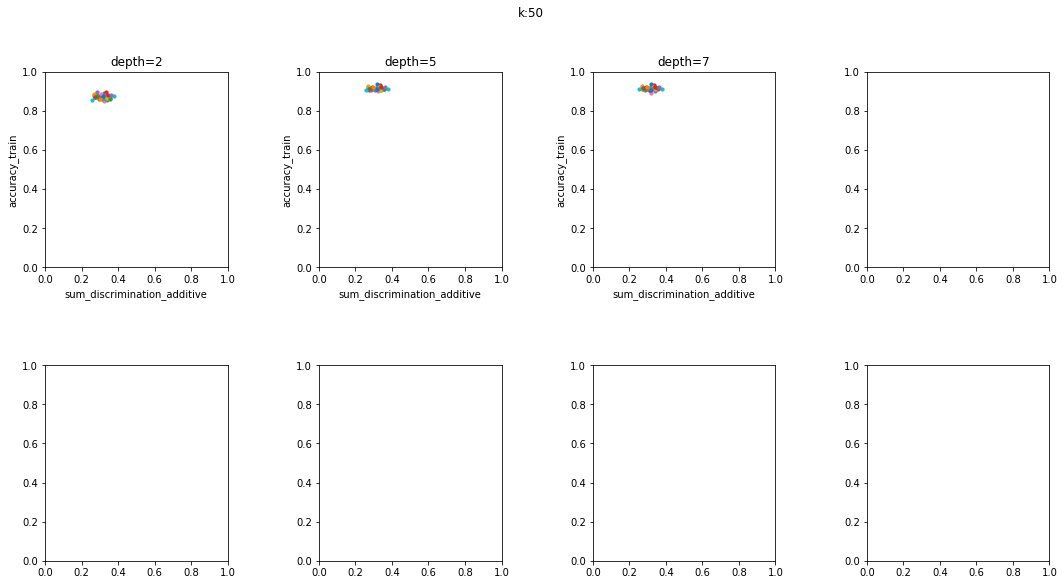

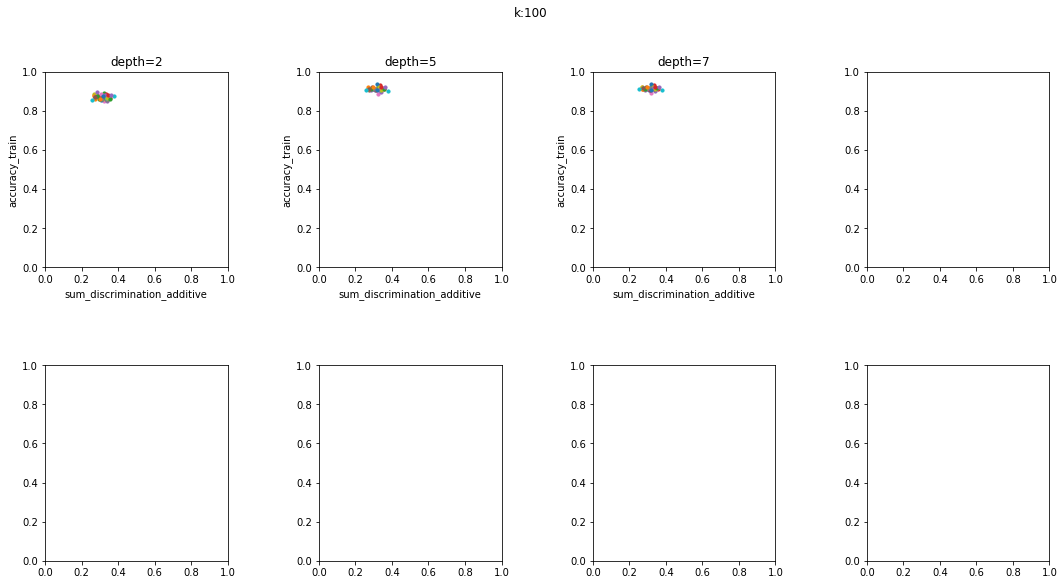

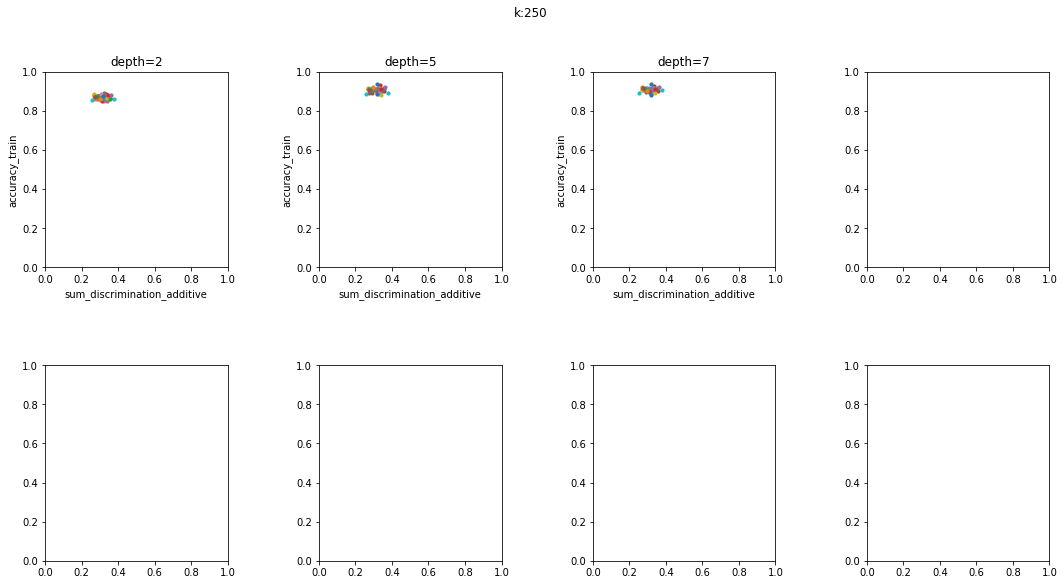

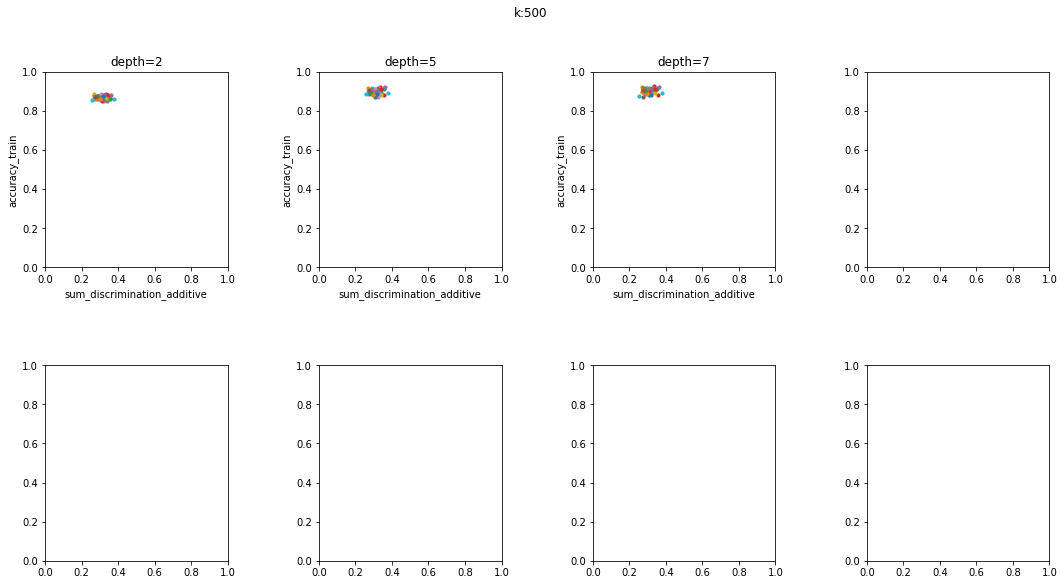

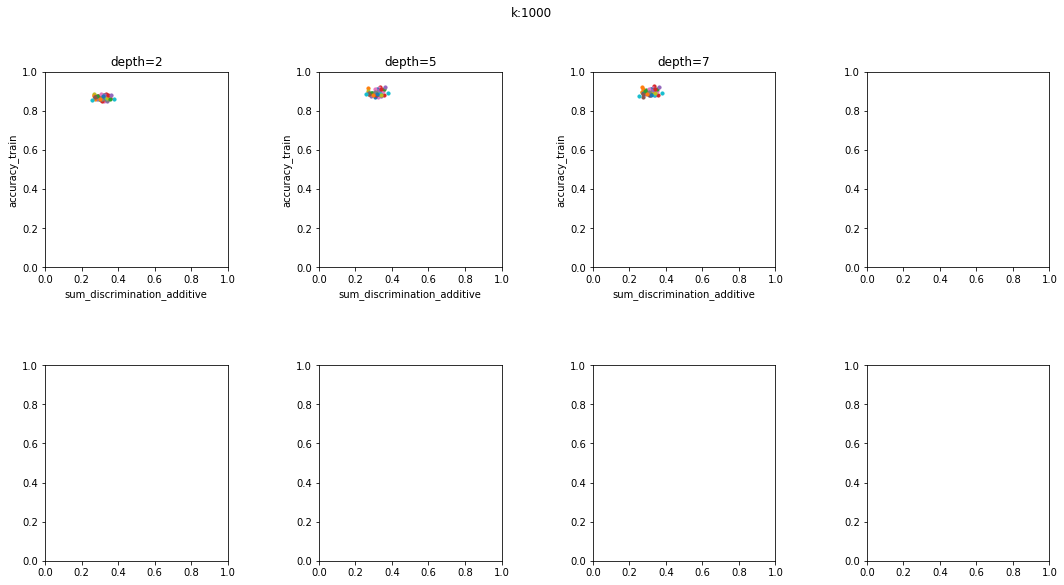

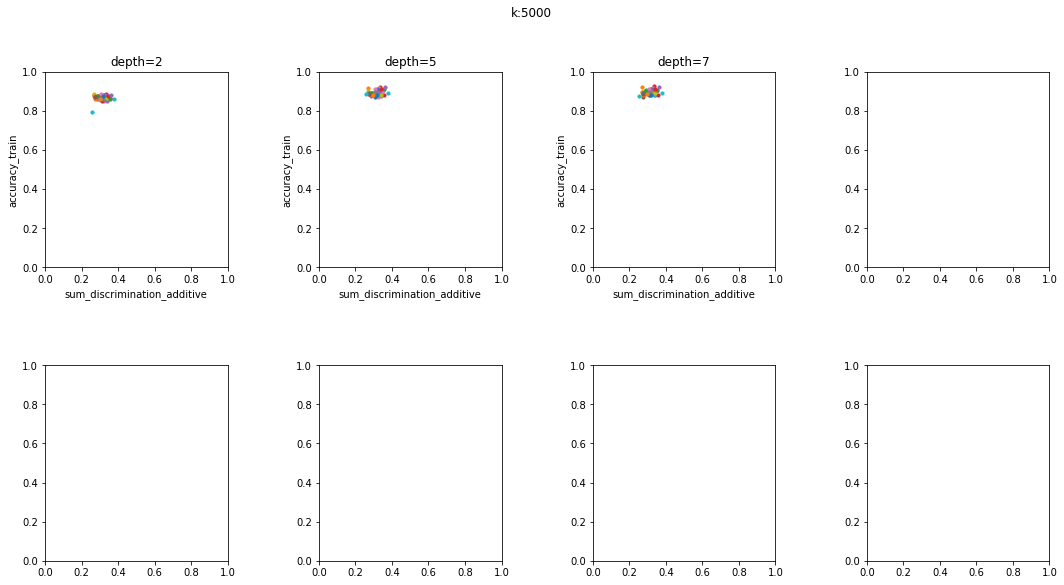

In [15]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive", "accuracy_train", result, (0, 1), (0, 1))

<Figure size 648x432 with 0 Axes>

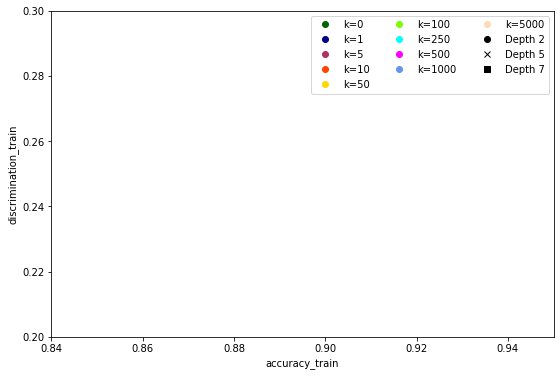

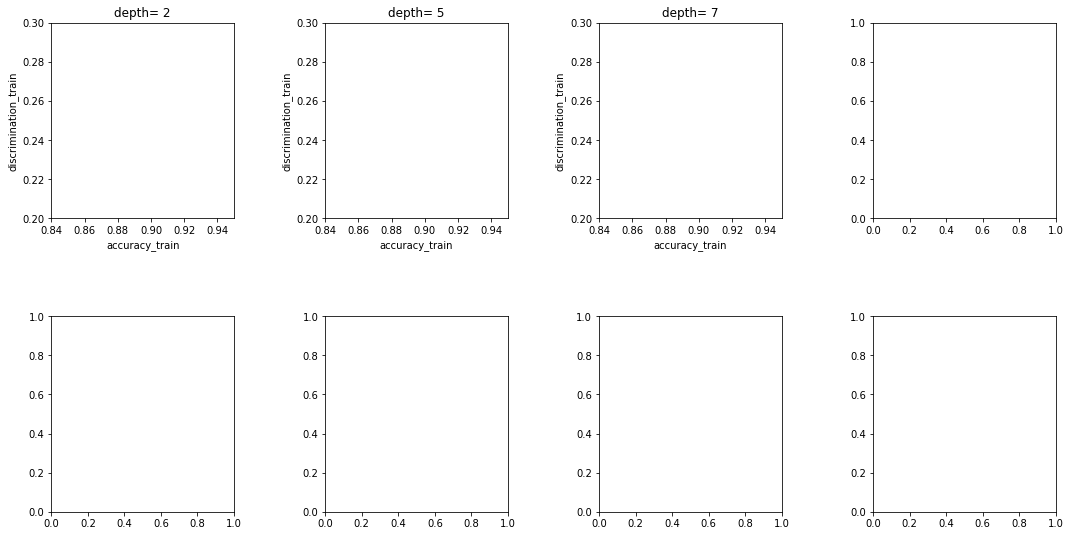

In [16]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_train", "discrimination_train", result, x_lim, y_lim)
#utils.plot_each_k_depth_mean("accuracy_train", "discrimination_train", result, (0.70, 1), (0, 0.35))
utils.plot_each_k_depth_mean("accuracy_train", "discrimination_train", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

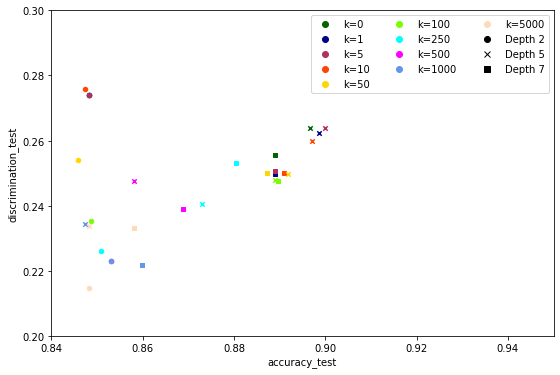

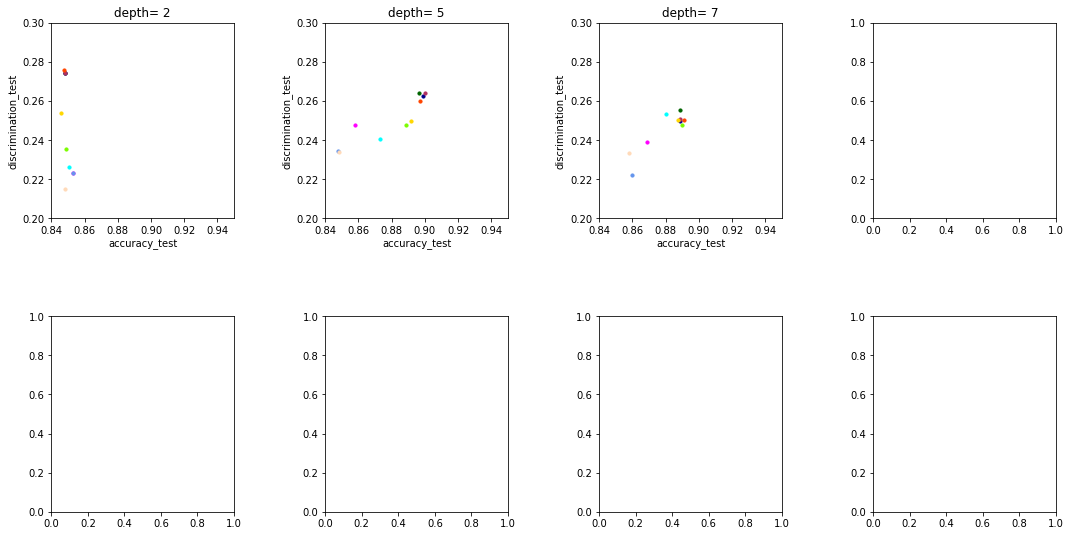

In [17]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

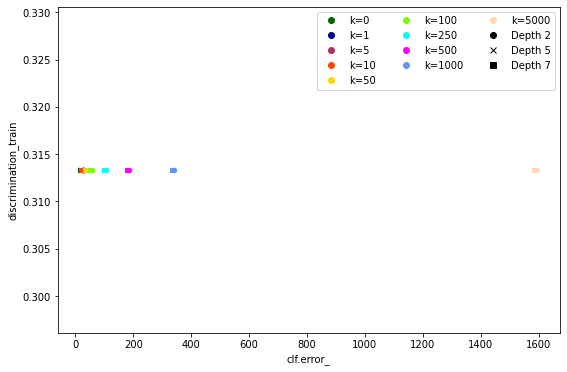

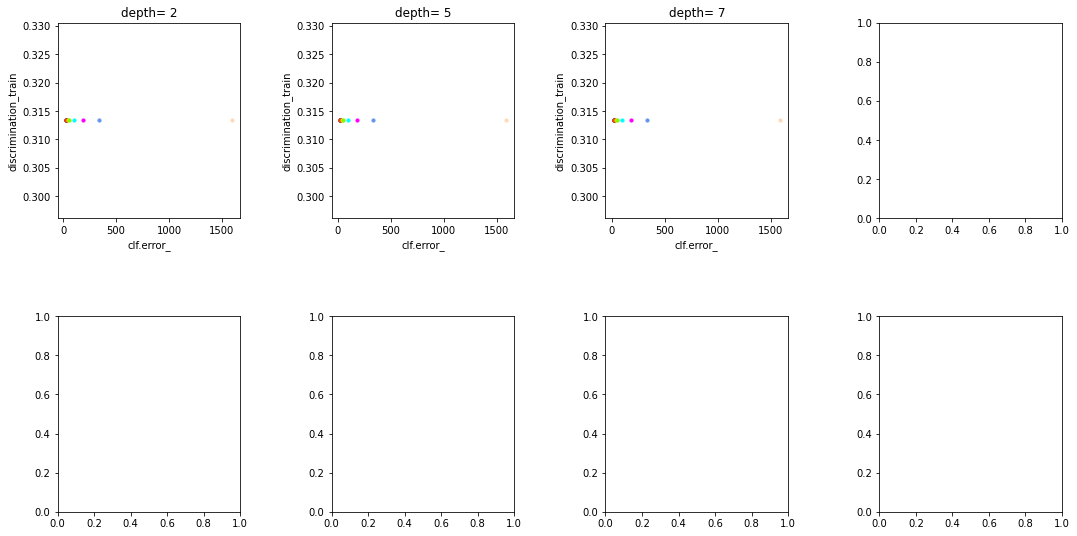

In [18]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("clf.error_", "discrimination_train", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("clf.error_", "discrimination_train", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

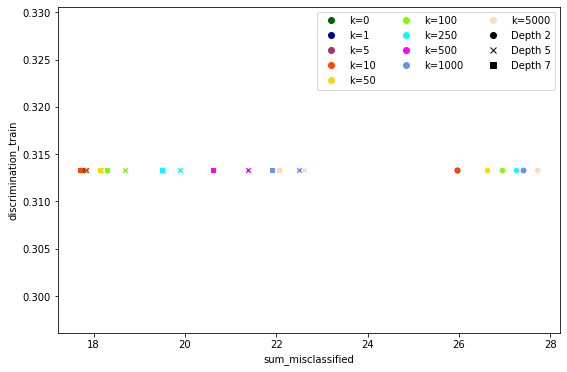

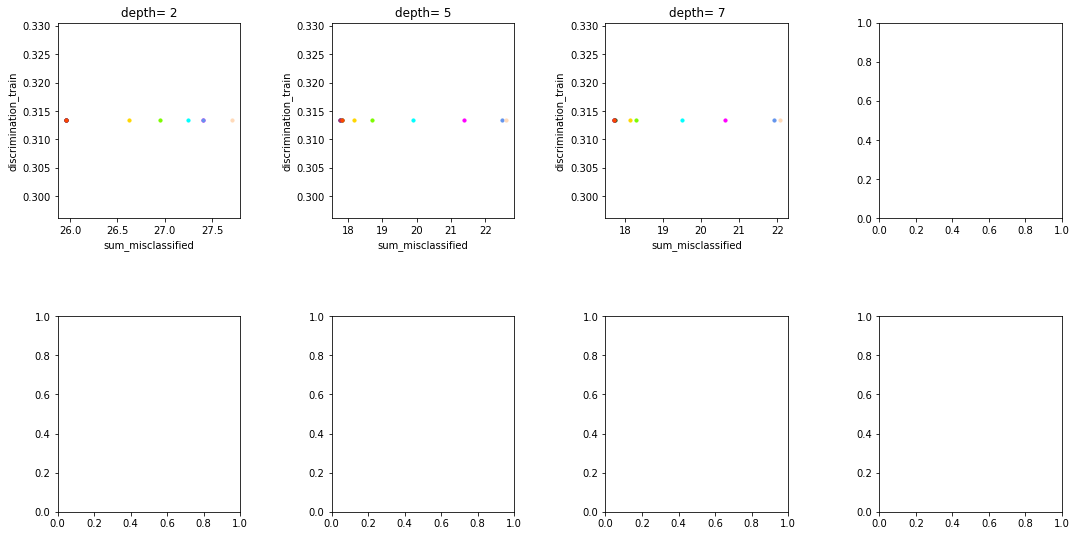

In [19]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified", "discrimination_train", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified", "discrimination_train", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

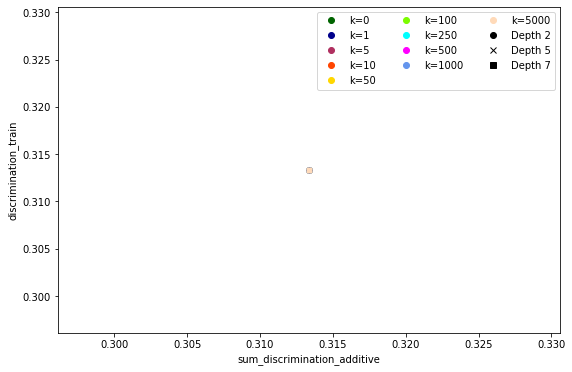

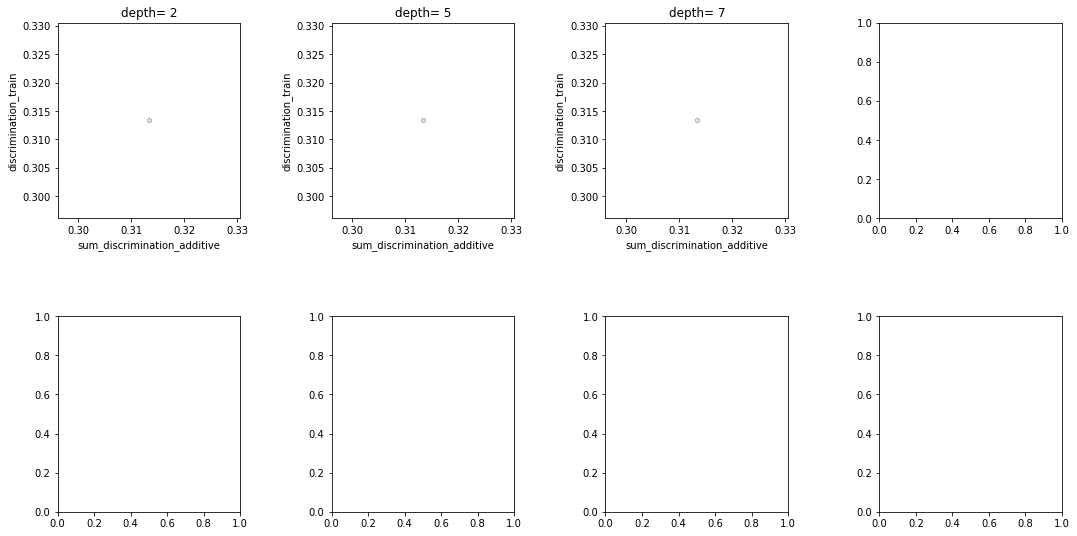

In [20]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive", "discrimination_train", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive", "discrimination_train", result, x_lim, y_lim)